In [ ]:
# Request game data from text and record url, store as json files, and process stats into csv file

from enum import IntEnum
from datetime import datetime, timedelta
from typing import List
import re # Needed for regular expression search
import os
import requests
import time
import json
import math
import random
import pandas as pd
import common as cmn

# --- Configuration ---
JSON_FOLDER = 'pitch_raw'
CSV_FOLDER = 'pitch_processed'
JSON_SUFFIX = 'raw'
CSV_SUFFIX = 'processed'

RECORD_URL = "https://api-gw.sports.naver.com/schedule/games/{}/record"
RELAY_URL = "https://api-gw.sports.naver.com/schedule/games/{}/relay?inning={}"

HEADERS = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/123.0.0.0 Safari/537.36',
    'Accept-Language': 'en-US,en;q=0.9',
}

class TextType(IntEnum):
    INNING_START = 0 # including start of half inning
    PITCH = 1
    SUBSTITUTION = 2
    TIMEOUT = 7 # Mound visit, VAR, pitcher leave mound, 우취
    PA_START = 8
    PA_RESULT_SELF = 13 # BB, HbP, Double play self out
    PA_RESULT_RUNNER = 14 # BB, Steal, Double play runner out, runner base run
    PA_RESULT_RBI_SELF = 23 # Hit, BB, 
    PA_RESULT_RBI_RUNNER = 24 # Hit, BB
    FOUL_ERROR = 44 # Foul fly catch error
    INNING_END = 99
# ---------------------

def _make_safe_request(url, max_retries=5):
    """
    Performs a request with anti-blocking measures: random delay and exponential backoff.
    Returns the Response object on success, or None on failure.
    """
    # Start with a conservative wait time
    wait_time = 2  
    
    for attempt in range(max_retries):
        try:
            # 1. Randomized Delay (The critical anti-blocking measure)
            delay = random.uniform(2.5, 9.5)
            time.sleep(delay)

            # 2. Make the request with standard headers
            response = requests.get(url, headers=HEADERS, timeout=30)
            
            # 3. Handle success
            if response.status_code == 200:
                return response
            
            # 4. Handle "Too Many Requests" (429) using exponential backoff
            elif response.status_code == 429:
                print(f"[{url}] Received 429 on attempt {attempt + 1}. Waiting {wait_time}s and retrying.")
                time.sleep(wait_time)
                wait_time *= 2  # Double the wait time (5, 10, 20, ...)
            
            # 5. Handle other HTTP errors (404, 500, etc.)
            else:
                response.raise_for_status() # Raises an exception for 4xx/5xx status codes
                
        except requests.exceptions.RequestException as e:
            cmn.log_warning(f"[{url}] Request failed on attempt {attempt + 1}: {e}")
            if attempt < max_retries - 1:
                # Wait before retrying on general network errors
                time.sleep(wait_time)
            
        except Exception as e:
             # Handle unexpected exceptions
             cmn.log_error(f"[{url}] Unexpected error: {e}")
             break

    cmn.log_error(f"[{url}] Failed to retrieve data after {max_retries} attempts.")
    return None

def _get_or_fetch_json(file_tag, month_folder, url_template, *url_args):
    """
    Checks for a local JSON file based on the file_tag. 
    If not found or corrupted, fetches the data from the constructed URL.
    
    Args:
        file_tag (str): A unique identifier for the file (e.g., 'gameId_record' or 'gameId_inning').
        url_template (str): The format string for the API URL (e.g., RECORD_URL, RELAY_URL).
        *url_args: Arguments to format the URL (e.g., game_id, inning_counter).

    Returns:
        dict: The loaded or fetched JSON data, or None if failed.
    """
    
    full_month_path = os.path.join(JSON_FOLDER, month_folder)
    os.makedirs(full_month_path, exist_ok=True)
    raw_file_path = os.path.join(full_month_path, f'{file_tag}_{JSON_SUFFIX}.json')
    data = None
    
    # --- 1. CHECK FOR EXISTING FILE ---
    if os.path.exists(raw_file_path):
        try:
            with open(raw_file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
                print(f"Loaded existing JSON")
                return data # Return immediately if successful
        except json.JSONDecodeError as e:
            cmn.log_error(f"Error loading existing JSON file {raw_file_path}: {e}. Proceeding to refetch.")
        except Exception as e:
            cmn.log_error(f"An unexpected error occurred while reading {raw_file_path}: {e}. Proceeding to refetch.")

    # --- 2. FETCH NEW DATA ---
    url = url_template.format(*url_args)

    response = _make_safe_request(url)

    if response and response.status_code == 200:
        try:
            data = response.json()
            
            # Save the Raw JSON
            with open(raw_file_path, 'w', encoding='utf-8') as f:
                json.dump(data, f, ensure_ascii=False, indent=4)
            print(f"  -> Successfully saved")
            return data
                
        except json.JSONDecodeError:
            cmn.log_error(f"Error decoding JSON from URL: {url}")
        
    else:
        # The request failed or returned a non-200 status
        cmn.log_warning(f"Failed to retrieve data from URL: {url}")
        
    return None # Return None on any fetch or decode failure
    
def _extract_game_data(data):
    """Safely extracts max_inning and PA list from the JSON data."""
    text_relay_data = data.get('result', {}).get('textRelayData', {})

    if text_relay_data is None:
        return 0, None
    
    # max_inning needs to be extracted as an integer
    try:
        max_inning = int(text_relay_data.get('inn', 0))
    except (TypeError, ValueError):
        max_inning = 0
        
    pa_list = text_relay_data.get('textRelays', [])

    # REVERSE THE LIST FOR CHRONOLOGICAL ORDER
    pa_list.reverse() 
    
    # The full data object is needed later to build the pitcher lookup (from inn 1 data)
    return max_inning, pa_list
    
def get_record_json_file(game_id):
    """
    Fetches/loads the game's record data and builds the batter/pitcher lookup tables.
    """
    month_folder = game_id[4:6]
    file_tag = f'{game_id}_record'
    data = _get_or_fetch_json(file_tag, month_folder, RECORD_URL, game_id)

    batter_record_lookup, pitcher_record_lookup = None, None
    
    if data:
        record_data = data.get('result', {}).get('recordData', {})
        if record_data and isinstance(record_data, dict):
            batter_record_lookup, pitcher_record_lookup = _build_record_lookup(record_data)
        else:
            batter_record_lookup = {}
            pitcher_record_lookup = {}
    
    return batter_record_lookup, pitcher_record_lookup

def get_json_files(game_id):
    """
    Fetches game data by inning, checks for existing files, and merges PA data.
    Returns: master_json_list (list of all PAs) and pitcher_lookup.
    """
    month_folder = game_id[4:6]
    
    inning_counter = 1
    max_inning = 1
    master_json_list = []
    pitcher_lookup = None

    while inning_counter <= max_inning:
        print(f"Processing Inning {inning_counter}...")
        file_tag = f'{game_id}_{inning_counter}'
        data = _get_or_fetch_json(file_tag, month_folder, RELAY_URL, game_id, inning_counter)

        if data is None:
            # If fetch/load failed, stop the loop.
            cmn.log_warning(f"Failed to retrieve data for Inning {inning_counter}. Stopping.")
            break
        
        if data:
            current_max_inning, pa_list = _extract_game_data(data)

            if current_max_inning < 4:
                print("Game canceled")
                break
            
            if inning_counter == 1:
                # Update max_inning based on the first inning's data
                max_inning = current_max_inning
                pitcher_lookup = _build_pitcher_lookup(data)
                print(f"Max inning set to: {max_inning}")

            if max_inning == 0:
                cmn.log_warning(f"Unable to get a valid max_inning (is 0). Stopping.")
                break
                
            if not pa_list:
                print(f"Inning {inning_counter} contains no Plate Appearances. Stopping.")
                break
            
            # Collect the 'textRelays' list for later merging
            master_json_list.extend(pa_list)
            inning_counter += 1

    print(f"\nFinished data collection. Total PA lists collected: {len(master_json_list)}")
    return master_json_list, pitcher_lookup

def _build_record_lookup(data):
    """
    Returns:
        dict: dictionary mapping player 'pcode' to their record data
    """
    batter_record_lookup = {}
    pitcher_record_lookup = {}
    
    batter_record = data.get('battersBoxscore', {})
    pitcher_record = data.get('pitchersBoxscore', {})
    away_batter_record = batter_record.get('away', [])
    home_batter_record = batter_record.get('home', [])
    away_pitcher_record = pitcher_record.get('away', [])
    home_pitcher_record = pitcher_record.get('home', [])
    
    for p in away_batter_record:
        pcode = p.get('playerCode')
        if pcode:
            batter_record_lookup[pcode] = p
        
    for p in home_batter_record:
        pcode = p.get('playerCode')
        if pcode:
            batter_record_lookup[pcode] = p
        
    for p in away_pitcher_record:
        pcode = p.get('playerCode')
        if pcode:
            pitcher_record_lookup[pcode] = p
        
    for p in home_pitcher_record:
        pcode = p.get('playerCode')
        if pcode:
            pitcher_record_lookup[pcode] = p
        
    return batter_record_lookup, pitcher_record_lookup

def _build_pitcher_lookup(full_inning_1_data):
    """
    Extracts pitcher data from the full Inning 1 game object and creates a lookup dictionary.

    Args:
        full_inning_1_data (dict): The full JSON object from the first inning fetch.

    Returns:
        dict: A dictionary mapping pitcher 'pcode' to their static data (name, stance, etc.).
    """
    pitcher_lookup = {}
    
    try:
        data = full_inning_1_data['result']['textRelayData']
        home_pitcher_list = data['homeLineup']['pitcher']
        away_pitcher_list = data['awayLineup']['pitcher']
        all_pitchers_list = away_pitcher_list + home_pitcher_list
        
        for p in all_pitchers_list:
            pcode = p.get('pcode')
            if pcode:
                # Pre-calculate stance for efficiency
                hit_type = p.get('hitType', 'L')
                p['stance_derived'] = 'R' if hit_type.startswith('우') else 'L'
                pitcher_lookup[pcode] = p
        
        return pitcher_lookup
        
    except (KeyError, TypeError) as e:
        cmn.log_error(f"Error building pitcher lookup from lineup data: {e}")
        return {}

# --- KINEMATICS AND ZONE CLASSIFICATION FUNCTIONS ---

def calculate_plate_height(pitch_data):
    """Calculates the flight time and the corrected vertical position (z_plate)."""
    try:
        y0 = pitch_data['y0']
        vy0 = pitch_data['vy0']
        ay = pitch_data['ay']
        z0 = pitch_data['z0']
        vz0 = pitch_data['vz0']
        az = pitch_data['az']
    except KeyError as e:
        # print(f"Missing required key in pitch data: {e}") # Suppress during bulk processing
        return None

    # Step 1: Calculate Flight Time (t)
    a = 0.5 * ay
    b = vy0
    c = y0
    discriminant = (b**2) - (4 * a * c)
    
    if discriminant < 0 or a == 0:
        return {"error": "Invalid kinematics data."}
    
    # Use the minus branch for the time to the plate (t > 0)
    time_of_flight = (-b - math.sqrt(discriminant)) / (2 * a)
    
    # Step 2: Calculate Vertical Position (z_plate)
    z_plate = z0 + (vz0 * time_of_flight) + (0.5 * az * (time_of_flight**2))

    return {
        "time_of_flight": time_of_flight,
        "z_plate": z_plate
    }

def classify_5x5_zone(crossPlateX, calculated_z, topSz, bottomSz):
    """
    Classifies a pitch into one of 25 zones (11 to 55) based on a 5x5 grid 
    (3x3 zone + 1 block shadow), and returns a flag if it is outside even the shadow.
    """
    
    # 1. Define Standard Baseball Constants
    PLATE_WIDTH_FT = 1.4167  # 17 inches
    HALF_PLATE = PLATE_WIDTH_FT / 2 # 0.70835
    
    # 2. Define Zone Block Sizes
    X_BLOCK = PLATE_WIDTH_FT / 3
    Z_BLOCK = (topSz - bottomSz) / 3
    
    # 3. Define X Boundaries (6 boundaries create 5 zones)
    x_boundaries = [
        -HALF_PLATE - X_BLOCK,   # X1: Far Left Shadow boundary
        -HALF_PLATE,             # X2: Left edge of plate
        -HALF_PLATE + X_BLOCK,   # X3: Left-center boundary
        HALF_PLATE - X_BLOCK,    # X4: Right-center boundary
        HALF_PLATE,              # X5: Right edge of plate
        HALF_PLATE + X_BLOCK     # X6: Far Right Shadow boundary
    ]
    
    # 4. Define Z Boundaries (6 boundaries create 5 zones)
    z_boundaries = [
        bottomSz - Z_BLOCK,      # Z1: Far Low Shadow boundary
        bottomSz,                # Z2: Bottom of Zone
        bottomSz + Z_BLOCK,      # Z3: Low-mid boundary
        topSz - Z_BLOCK,         # Z4: Mid-high boundary
        topSz,                   # Z5: Top of Zone
        topSz + Z_BLOCK          # Z6: Far High Shadow boundary
    ]
    
    # Determine the X-Index -1, (0 to 4), 5
    x_index = -1
    is_out_bound = False
    for i, boundary in enumerate(x_boundaries):
        if crossPlateX < boundary:
            x_index = i
            break
    else:
        x_index = 5

    # Determine the Z-Index -1, (0 to 4), 5
    z_index = -1
    for i, boundary in enumerate(z_boundaries):
        if calculated_z < boundary:
            z_index = i
            break
    else:
        z_index = 5


    # --- Determine Outside Boundary Flag ---
    # The flag is True if the pitch is outside the 5x5 grid (index 0 or 5)
    is_outside_boundary = (x_index == 0) or (x_index == 5) or \
                              (z_index == 0) or (z_index == 5)
    
    # --- Calculate Final Zone ID (clamping index to 1-5) ---
    # Clamp the index between 1 and 5 (index 0 maps to zone 1, index 5 maps to zone 5)
    # This prevents the final Zone ID from being 00 or 66, but still flags the issue.
    # Note: Zone ID 1x is the low row, 5x is the high row.
    final_z_index = max(1, min(z_index, 5))
    final_x_index = max(1, min(x_index, 5))

    # Zone ID (e.g., Row 1 x 10 + Col 1 = 11, Row 5 x 10 + Col 5 = 55)
    zone_id = final_z_index * 10 + final_x_index
    
    return {
        "zone_5x5_id": str(zone_id),
        "is_outside_boundary": is_outside_boundary,
        "raw_x_index": x_index,
        "raw_z_index": z_index
    }

def _count_pa_home_in(text):
    """
    count home in during this pa, not from errors or steals, but from RBI
    """
    home_in = '홈인'
    home_run = '홈런'
    error = '실책'
    steal = '도루'

    if ((home_in in text) | (home_run in text)) & (error not in text) & (steal not in text):
        return 1

    return 0

def process_plate_appearance(game_id, pa_data, pitcher_lookup, away_code, home_code, batter_record_lookup, pitcher_record_lookup):
    """
    Processes all events
    within a single Plate Appearance (PA), correctly linking context to pitch data.
    Returns a list of dictionaries, one for each processed pitch (type 1).
    """
    processed_pitches_in_pa = []

    # Create a MAP for Trajectory Data (ptsOptions)
    # Key: pitchId (e.g., "251007_151509")
    # Value: The full trajectory dict
    trajectory_map = {
        pitch.get('pitchId'): pitch
        for pitch in pa_data.get('ptsOptions', [])
    }
    
    # Contextual variables to be updated by Type 8 events
    current_batter_name = 'N/A'
    current_batter_lineup_pos = 'N/A'
    current_batter_id = 'N/A' 
    is_batter_home = pa_data.get('homeOrAway') == "1"
    inn = pa_data.get('inn', 0)

    # Determine static PA team codes
    batter_team_code = home_code if is_batter_home else away_code
    pitcher_team_code = away_code if is_batter_home else home_code

    # Check for pitcher change SUBSTITUTION
    #pitcher_data = pitcher_lookup.get(pitcher_id, {})
    #pitcher_name = pitcher_data.get('name', 'N/A')
    #pitcher_stance = pitcher_data.get('stance_derived', 'L') # Using pre-derived stance

    text_options = pa_data.get('textOptions', [])
    pa_result_long = 'N/A'
    pa_result_base1 = 'N/A'
    pa_result_base2 = 'N/A'
    pa_result_base3 = 'N/A'
    pa_result_runs = 0
    
    # Iterate backward through Text Events (to get results)
    is_first_iteration = True
    for detail in reversed(text_options):
        if is_first_iteration:
            currentGameState = detail.get('currentGameState', {})
            pa_result_base1 = currentGameState.get('base1')
            pa_result_base2 = currentGameState.get('base2')
            pa_result_base3 = currentGameState.get('base3')
            is_first_iteration = False
        
        event_type = detail.get('type')
        match event_type:
            # even if inning ends not because of batter, need to record pa_result_base?
            case TextType.PA_RESULT_RUNNER:
                #pa_result = detail.get('text')
                pa_result = ''
            case TextType.PA_RESULT_RBI_RUNNER:
                text = detail.get('text').split(": ",1)[1]
                pa_result_runs += _count_pa_home_in(text)
            case TextType.PA_RESULT_SELF | TextType.PA_RESULT_RBI_SELF:
                pa_result_long = detail.get('text').split(": ",1)[1]
                pa_result_runs += _count_pa_home_in(pa_result_long)
            case TextType.PITCH:
                break

    before_strike = 'N/A'
    before_ball = 'N/A'
    before_out = 'N/A'
    # Iterate forward through Text Events (textOptions)
    for detail in text_options:
        event_type = detail.get('type')
        match event_type:
            case TextType.PA_START:
                batter_record = detail.get('batterRecord', {})
                if not batter_record:
                    break
                
                current_batter_name = batter_record.get('name', 'N/A')
                current_batter_lineup_pos = batter_record.get('batOrder', 'N/A')
                current_batter_id = batter_record.get('pcode', 'N/A')
            case TextType.PITCH:
                pitch_id = detail.get('ptsPitchId')
                pitch = trajectory_map.get(pitch_id)
    
                # --- A. MERGE DATA & CALCULATIONS ---
                
                pitch_summary = {}
                pitch_summary['game_id'] = game_id
                
                pitch_summary['plate_z_ft'] = None
                zone_5x5_id = 0
                is_outside_boundary = False
                
                # This pitch event exists in textOptions but has Trajectory Data (ptsOptions)
                if pitch is None:
                    pitch_summary['pitchId'] = pitch_id
                    pitch_summary['inn'] = inn
                else:
                    pitch_summary.update(pitch)
                    # Kinematic Calculations
                    calculation_result = calculate_plate_height(pitch)

                    if calculation_result:
                        calculated_z = calculation_result.get('z_plate')
                        zone_results = classify_5x5_zone(
                            pitch.get('crossPlateX', 0.0), calculated_z, 
                            pitch.get('topSz', 3.3), pitch.get('bottomSz', 1.6)
                        )
                        pitch_summary['plate_z_ft'] = round(calculated_z, 4)
                        zone_5x5_id = zone_results['zone_5x5_id']
                        is_outside_boundary = zone_results['is_outside_boundary']
    
                # --- B. ADD CONTEXTUAL & PITCH DATA ---
                
                pitcher_id = currentGameState.get('pitcher')
                pitcher_data = pitcher_lookup.get(pitcher_id, {})
    
                # 1. Game State
                pitch_summary['is_batter_home'] = is_batter_home
                pitch_summary['home_score'] = currentGameState.get('homeScore')
                pitch_summary['away_score'] = currentGameState.get('awayScore')
                pitch_summary['strike'] = before_strike
                pitch_summary['ball'] = before_ball
                pitch_summary['out'] = before_out
                pitch_summary['base1'] = currentGameState.get('base1')
                pitch_summary['base2'] = currentGameState.get('base2')
                pitch_summary['base3'] = currentGameState.get('base3')
    
                # 3. Pitcher Info (From currentGameState)
                pitch_summary['pitcher_id'] = pitcher_id
                hit_type = pitcher_data.get('hitType', 'L') # Check for the '우' (Right) character in 'hitType' X투X타
                pitch_summary['pitcher_stance'] = 'R' if hit_type.startswith('우') else 'L'
                pitch_summary['pitcher_team_code'] = pitcher_team_code
                pitch_summary['pitcher_name'] = pitcher_data.get('name', 'N/A')
            
                # 2. Batter Info (From Type 8 event)
                pitch_summary['batter_id'] = current_batter_id
                pitch_summary['batter_team_code'] = batter_team_code
                pitch_summary['batter_lineup_pos'] = current_batter_lineup_pos
                pitch_summary['batter_name'] = current_batter_name
    
                # 4. Pitch Details
                pitch_summary['is_throwing_stretch'] = (pitch_summary['base1'] != '0') or \
                                                     (pitch_summary['base2'] != '0') or \
                                                     (pitch_summary['base3'] != '0')
                
                pitch_summary['pitch_type'] = detail.get('stuff', 'N/A')
                pitch_summary['pitch_speed_kph'] = detail.get('speed', 'N/A')
                pitch_summary['pitch_result'] = detail.get('pitchResult', 'N/A')
                pitch_summary['is_outside_boundary'] = is_outside_boundary
                pitch_summary['zone_5x5_id'] = zone_5x5_id

                batter_record = batter_record_lookup.get(current_batter_id, {})
                pa_result_short = batter_record.get(f'inn{inn}', 'N/A')
                if pa_result_short == 'N/A':
                    cmn.log_warning(f"current_batter_id NOT FOUND: {inn}, {detail.get('text', 'N/A')}, {current_batter_name}, {current_batter_lineup_pos}, {current_batter_id}")

                pitch_summary['pa_result_long'] = pa_result_long
                pitch_summary['pa_result_short'] = pa_result_short
                pitch_summary['pa_result_base1'] = pa_result_base1
                pitch_summary['pa_result_base2'] = pa_result_base2
                pitch_summary['pa_result_base3'] = pa_result_base3
                pitch_summary['pa_result_runs'] = pa_result_runs
                
                processed_pitches_in_pa.append(pitch_summary)
            case TextType.PA_RESULT_SELF | TextType.PA_RESULT_RBI_SELF:
                break
            case TextType.INNING_START | TextType.SUBSTITUTION | TextType.TIMEOUT | \
                    TextType.PA_RESULT_RUNNER | TextType.PA_RESULT_RBI_RUNNER | \
                    TextType.INNING_END | TextType.FOUL_ERROR:
                pass
            case _:
                cmn.log_warning(f"Unknown Text Type: {event_type} {detail.get('text')}")
        
        currentGameState = detail.get('currentGameState', {})
        before_strike = currentGameState.get('strike')
        before_ball = currentGameState.get('ball')
        before_out = currentGameState.get('out')
    
    return processed_pitches_in_pa

def main_processing_script(game_id):
    away_code, home_code = extract_team_codes(game_id)
    batter_record_lookup, pitcher_record_lookup = get_record_json_file(game_id)
    master_pa_list, pitcher_lookup = get_json_files(game_id)

    if not master_pa_list:
        print("No plate appearances found. Exiting.")
        return pd.DataFrame()

    all_processed_pitches = []

    # 3. Process all Plate Appearances
    for i, pa_data in enumerate(master_pa_list):
        pitches_in_pa = process_plate_appearance(game_id, pa_data, pitcher_lookup, away_code, home_code, batter_record_lookup, pitcher_record_lookup)
        all_processed_pitches.extend(pitches_in_pa)

    print(f"Total pitches processed: {len(all_processed_pitches)}")

    # 4. Convert to Pandas DataFrame and Clean
    df = pd.DataFrame(all_processed_pitches)

    df.rename(columns={
        'pitchId': 'pitch_id',
        'crossPlateX': 'plate_x_ft',
        'ballcount': 'ball_count',
        'crossPlateY': 'plate_y_ft',
        'topSz': 'strikezone_top',
        'bottomSz': 'strikezone_btm',
        'stance': 'batter_stance',
        'inn': 'inning'
    }, inplace=True)
    
    # 5. Output the Results
    if not df.empty:
        output_filename = f'./{CSV_FOLDER}/{game_id}_{CSV_SUFFIX}.csv'
        df.to_csv(output_filename, index=False, encoding='utf-8')
        
        print(f"\n--- Final Processed DataFrame Saved to {output_filename} ---")
        print(f"No. of Columns: {len(all_processed_pitches[0])}")
    else:
        cmn.log_warning(f"\n--- DF is empty. Skipping output. ---")
    
    return df

def get_lotte_game_ids(start_date_str: str, end_date_str: str) -> List[str]:
    """
    Scrapes Naver Sports KBO schedule pages month-by-month to find unique game IDs 
    for a specified team within a given date range.

    Args:
        team_code (str, optional): The KBO team code to filter for. Defaults to 'LT' (Lotte).

    Returns:
        List[str]: A sorted list of unique KBO game IDs.
    """
    all_game_ids: List[str] = list()
    
    start_date = datetime.strptime(start_date_str, "%Y-%m-%d")
    end_date = datetime.strptime(end_date_str, "%Y-%m-%d")

    current_date = start_date.replace(day=1)
    
    # 1. Iterate through the required months
    while current_date <= end_date:
        date_str = current_date.strftime("%Y-%m-%d")
        month_string = current_date.strftime('%m')

        print(f"Retrieving month record for {date_str}")
        schedule_url = f"https://api-gw.sports.naver.com/schedule/calendar?upperCategoryId=kbaseball&categoryIds=kbo&date={date_str}"
        file_tag = f'{date_str}_month_matches'
        data = _get_or_fetch_json(file_tag, month_string, schedule_url)

        if data:
            try:
                dates_list = data.get('result').get('dates', [])
                print(len(dates_list))
                for date in dates_list:
                    game_id_list = date.get('gameIds', [])
                    all_game_ids.extend(game_id_list)
                            
            except requests.exceptions.RequestException as e:
                cmn.log_error(f"Error fetching data for {url}: {e}")
                continue
                
            except Exception as e:
                cmn.log_error(f"An unexpected error occurred while parsing {url}: {e}")
                continue
        else:
            cmn.log_warning("Response is bad.")
        
        # Move to the next month for iteration
        if current_date.month == 12:
            current_date = current_date.replace(year=current_date.year + 1, month=1, day=1)
        else:
            current_date = current_date.replace(month=current_date.month + 1, day=1)

        # Stop if we've passed the end date
        if current_date.strftime("%Y%m") > end_date.strftime("%Y%m") and current_date.day == 1:
            break

    print(f"\nFound {len(all_game_ids)} unique game IDs.")
    print(all_game_ids)
    return sorted(all_game_ids)

# --- Execution Example ---
if __name__ == '__main__':
    # takes month and year, but ignores day
    START_DATE = '2023-03-01'
    END_DATE = '2023-11-01'

    all_lotte_ids = get_lotte_game_ids(START_DATE, END_DATE)
    total_count = len(all_lotte_ids)
    current_count = 1
    for game_id in all_lotte_ids:
        print(f"\nProcessing {current_count} of {total_count}: Game ID {game_id}")
        main_processing_script(game_id)
        current_count += 1

    print("\n--- All games processed successfully! ---")

In [ ]:
# validating collected data against naver's scoreboard

import pandas as pd
import numpy as np
import common as cmn

KBO_PA_RESULT_MAP = {
    # --- Walks & HBP (BB / HBP) ---
    '4구': 'BB',    # Walk (Base on Balls)
    '고4': 'BB',     # Intentional Walk (고의사구) - analytically still a BB
    '사구': 'BB',   # Hit By Pitch (HBP) - analytically still a BB

    # --- Strikeout (K) ---
    '삼진': 'K',     # Strikeout
    '스낫': 'NK',      # Strike not out (Dropped Third Strike) - counts as K, but not Out

    # --- Special/Other ---
    '야선': 'FC',    # Fielder's Choice (야수선택)
}
    
# --- Helper Functions for Validation ---

def standardize_pa_result(kbo_shorthand):
    """Converts KBO shorthand to a standard analytical result type."""
    if pd.isna(kbo_shorthand):
        return None
        
    kbo_shorthand = str(kbo_shorthand).strip().upper()

    # 1. Check for perfect matches
    if kbo_shorthand in KBO_PA_RESULT_MAP:
        return KBO_PA_RESULT_MAP[kbo_shorthand]

    # 2. Check for partial matches or specific patterns
    
    # Pattern for Field-Specific Outs
    # These often end in a common type: 땅(GO), 비(FO), 직(LO)
    if kbo_shorthand.endswith('땅'):
        return 'GO'
    if kbo_shorthand.endswith('병'): # 병살
        return 'GO'
    if kbo_shorthand.endswith('비'): # 비행
        return 'FO'
    if kbo_shorthand.endswith('파'): # 파울플라이
        return 'FO'
    if kbo_shorthand.endswith('직'):
        return 'LO'
    if kbo_shorthand.endswith('희'): # 희생
        return 'SAC'
    if kbo_shorthand.endswith('희번'): # 희생 번트
        return 'SAC'
    if kbo_shorthand.endswith('실'): # 실책
        return 'E'
        
    if kbo_shorthand.endswith('안'):
        return '1B'
    if kbo_shorthand.endswith('2'):
        return '2B'
    if kbo_shorthand.endswith('3'):
        return '3B'
    if kbo_shorthand.endswith('홈'):
        return 'HR'
    
    # Fallback for unknown codes (helps identify missing codes in the map)
    print(f"Warning: Unknown KBO shorthand '{kbo_shorthand}' encountered.")
    return 'UNKNOWN'

# missing 이닝, 자책
def calculate_pitcher_stats(df):
    # 1. Group by Pitcher and PA using the standardized column
    # Use the standardized column for filtering duplicates and defining the PA result
    pa_results = df.dropna(subset=['standard_result']).drop_duplicates(
        subset=['pitcher_id', 'batter_id', 'inning', 'batter_team_code'], 
        keep='last' 
    )
    
    # Prepare runs data (using 'pa_result_runs')
    pa_results['Runs_Allowed'] = pd.to_numeric(pa_results['pa_result_runs'], errors='coerce').fillna(0)
    
    # 2. Total Pitch Count (Remains the same)
    pitch_counts = df.groupby('pitcher_id')['pitch_id'].count().reset_index(name='Count')

    # 3. Plate Appearance Results (K, BB, H, AB) using the standardized codes
    pitcher_pa_stats = pa_results.groupby('pitcher_id').agg(
        # HITS (안타)
        H=('standard_result', lambda x: (x.isin(['1B', '2B', '3B', 'HR'])).sum()),
        # HOME RUNS ALLOWED (피홈런)
        HR=('standard_result', lambda x: (x == 'HR').sum()),
        # WALKS (볼넷)
        BB=('standard_result', lambda x: (x == 'BB').sum()),
        # STRIKEOUTS (삼진)
        K=('standard_result', lambda x: (x.isin(['K', 'NK'])).sum()),
        # HIT BY PITCH (사구)
        HBP=('standard_result', lambda x: (x == 'HBP').sum()),
        # SACRIFICE (희생타)
        SF_SAC=('standard_result', lambda x: (x.isin(['SF', 'SAC'])).sum()),
        # OUTS RECORDED
        Out=('standard_result', 
                       lambda x: (~x.isin(['1B', '2B', '3B', 'HR', 'BB', 'HBP', 'E', 'NK'])).sum()),
        # TOTAL PLATE APPEARANCES (타석)
        PA=('standard_result', 'count'),
        # TOTAL RUNS ALLOWED (실점)
        R=('Runs_Allowed', 'sum')
    ).reset_index()

    # 4. Calculate At Bats (타수)
    pitcher_pa_stats['AB'] = pitcher_pa_stats['PA'] - pitcher_pa_stats['BB'] - \
                           pitcher_pa_stats['HBP'] - pitcher_pa_stats['SF_SAC']
                           
    # 5. Merge and Finalize (remaining steps are the same)
    pitcher_report = pitch_counts.merge(pitcher_pa_stats, on='pitcher_id', how='left')

    pitcher_name_map = df.drop_duplicates(subset=['pitcher_id']).set_index('pitcher_id')['pitcher_name'] 
    pitcher_report['Name'] = pitcher_report['pitcher_id'].map(pitcher_name_map)

    pitcher_team_map = df.drop_duplicates(subset=['pitcher_id']).set_index('pitcher_id')['pitcher_team_code'] 
    pitcher_report['Team'] = pitcher_report['pitcher_id'].map(pitcher_team_map)
    
    # 6. Calculate IP (Innings Pitched) in the fractional X.Y format
    pitcher_report['IP_Outs'] = pitcher_report['Out'] // 3
    pitcher_report['IP_Remain'] = pitcher_report['Out'] % 3
    # Format as string X.Y (e.g., 5.1, 5.2, 6.0)
    pitcher_report['IP'] = pitcher_report['IP_Outs'].astype(str) + ',' + pitcher_report['IP_Remain'].astype(str)

    # 7. Final Output
    return pitcher_report[['Team', 'Name', 'IP', 'Count', 'PA', 'AB', 'H', 'HR', 'R', 'BB', 'K']].sort_values(by='Team', ascending=False)

def calculate_batter_stats(df):
    """
    Calculates key batter metrics (PA, R, H, RBI, HR, BB, K) 
    using standardized PA results and runs scored data.
    """
    
    # 1. Ensure standardization has run (if not already done)
    if 'standard_result' not in df.columns:
        df['standard_result'] = df['pa_result_short'].apply(standardize_pa_result)

    # 2. Filter for final PA results (one row per Plate Appearance)
    pa_results = df.dropna(subset=['standard_result']).drop_duplicates(
        subset=['pitcher_id', 'batter_id', 'inning', 'batter_team_code'], 
        keep='last'
    )
    
    # This column must contain the total number of runs that scored *due to this PA*
    pa_results['runs_on_play'] = pd.to_numeric(pa_results['pa_result_runs'], errors='coerce').fillna(0)


    # 3. Aggregate Batter Statistics
    batter_report = pa_results.groupby('batter_id').agg(
        # TOTAL PLATE APPEARANCES (타석)
        PA=('standard_result', 'count'),
        # HITS (안타)
        H=('standard_result', lambda x: (x.isin(['1B', '2B', '3B', 'HR'])).sum()),
        # HOME RUNS (홈런) - subset of Hits
        HR=('standard_result', lambda x: (x == 'HR').sum()),
        # WALKS (볼넷) + HBP - Assuming 'BB' standard result is for both 4구, 고4, and 사구
        BB=('standard_result', lambda x: (x == 'BB').sum()),
        # STRIKEOUTS (삼진)
        K=('standard_result', lambda x: (x == 'K').sum()),
        # SACRIFICE (희생타) - Needed for AB calculation
        SF_SAC=('standard_result', lambda x: (x.isin(['SF', 'SAC'])).sum()),
        # RUNS BATTED IN (타점) - Total runs scored *on this PA* (requires pa_result_runs)
        # We assume runs_on_play includes the batter if they hit a HR, but RBI calculation
        # is typically runs_on_play minus the run scored by the batter if they score on non-HR.
        # For simple validation, we use total runs scored on the play.
        # Note: True RBI logic is complex (e.g., doesn't count if batter gets K/GO/FO on error).
        # We will use a simple proxy for now:
        RBI_PROXY=('runs_on_play', 'sum')
    ).reset_index()

    # 4. Calculate At Bats (타수)
    # AB = PA - BB - HBP - SF - SAC. Since 'BB' includes HBP in your map, we simplify.
    # If HBP needs to be tracked separately for official AB calculation, you must adjust KBO_PA_RESULT_MAP
    # to differentiate between 'BB' (walk) and 'HBP'. For now, we assume your map handles it correctly.
    batter_report['AB'] = batter_report['PA'] - batter_report['BB'] - batter_report['SF_SAC']

    # 5. Get Runs Scored (R)
    # This requires identifying when a runner (including the batter) crossed home plate.
    # The simplest proxy: runs scored is R = sum of all runs scored on PAs by the *player's team* # when the *player* was the batter, where the batter also scores if they hit a HR.
    # The true R stat is complex, so we will skip it for this first pass of validation.
    # If you need R, you'll need a separate column that tracks whether the batter themselves scored (usually if they hit a HR and the bases weren't loaded).
    # For now, we'll keep the focus on *offensive production*: H, HR, RBI.
    
    # 6. Map Player Info (using the corrected mapping logic)
    batter_name_map = df.drop_duplicates(subset=['batter_id']).set_index('batter_id')['batter_name']
    batter_report['Name'] = batter_report['batter_id'].map(batter_name_map)
    
    batter_team_map = df.drop_duplicates(subset=['batter_id']).set_index('batter_id')['batter_team_code']
    batter_report['Team'] = batter_report['batter_id'].map(batter_team_map)

    # 7. Final Output Cleanup and Rename
    batter_report = batter_report.rename(columns={'RBI_PROXY': 'RBI', 'K': 'SO'})

    return batter_report[['Team', 'Name', 'PA', 'AB', 'H', 'HR', 'RBI', 'BB', 'SO']].sort_values(by='Team', ascending=False)

game_id = '20250629KTLT02025'
df = pd.read_csv(f"pitch_processed/{game_id}_processed.csv")
df['standard_result'] = df['pa_result_short'].apply(standardize_pa_result)

pitcher_validation_df = calculate_pitcher_stats(df)
batter_validation_df = calculate_batter_stats(df)

print (f"df length: {len(df)}")
print(f"pitch total: {pitcher_validation_df['Count'].sum()}")

print("\n" + "="*50)
print("Pitcher Validation Report")
print("="*50)
print(pitcher_validation_df)

print("\n" + "="*50)
print("Batter Validation Report")
print("="*50)
print(batter_validation_df)

In [ ]:
# Plot pitch

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm # For color maps

def plot_pitch_trajectories(df, game_id):
    """
    Generates a scatter plot of pitch locations (X vs Z) for all pitchers.
    
    Args:
        df (pd.DataFrame): The pitch-by-pitch DataFrame.
    """
    plt.rcParams['font.family'] = ['Noto Serif KR']  # Set the font family

    x_col = 'plate_x_ft'
    z_col = 'plate_z_ft'
    pitch_type = 'pitch_type'
    
    # 1. Get all unique pitchers, their teams, and sort by team code
    pitcher_info = df[['pitcher_id', 'pitcher_team_code', 'pitcher_name']].drop_duplicates(subset=['pitcher_id'])
    pitcher_info = pitcher_info.sort_values(by=['pitcher_team_code', 'pitcher_id'])
    
    sample_pitchers = pitcher_info['pitcher_id'].tolist()
    num_pitchers = len(sample_pitchers)
    
    if num_pitchers == 0: 
        print("Error: No unique pitchers found in the data.")
        return
        
    # 2. Set up the plotting grid (dynamic sizing)
    # Use max 3 columns for readability, adjusting rows accordingly
    cols = min(num_pitchers, 3) 
    rows = int(np.ceil(num_pitchers / cols))
    
    # Increase figsize dynamically
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(5 * cols, 5 * rows), sharex=True, sharey=True)
    axes = axes.flatten() if num_pitchers > 1 else [axes]
    
    # Handle cases where the number of subplots exceeds the number of pitchers
    for i in range(num_pitchers, len(axes)):
        fig.delaxes(axes[i])
        
    # Get average strike zone dimensions
    sz_top_avg = df['strikezone_top'].mean()
    sz_bot_avg = df['strikezone_btm'].mean()
    sz_width = 1.416 # Standard 17 inches in feet (17/12)
    
    # Prepare colors for pitch types
    unique_pitch_types = df[pitch_type].unique()
    unique_pitch_types = [pt for pt in unique_pitch_types if pd.notna(pt)]
    
    # Use a colormap to get distinct colors
    colors = cm.get_cmap('tab10', len(unique_pitch_types))
    pitch_type_color_map = {pt: colors(i) for i, pt in enumerate(unique_pitch_types)}
    
    # 3. Iterate and plot each pitcher
    for i, pitcher_id in enumerate(sample_pitchers):
        ax = axes[i]
        
        # Filter data for the current pitcher
        pitcher_data = df[df['pitcher_id'] == pitcher_id].copy()
        
        info = pitcher_info[pitcher_info['pitcher_id'] == pitcher_id].iloc[0]
        pitcher_name = info['pitcher_name']
        pitcher_team = info['pitcher_team_code']
        
        # Scatter Plot - now colored by pitch type
        for pt in unique_pitch_types:
            subset = pitcher_data[pitcher_data[pitch_type] == pt]
            ax.scatter(subset[x_col], subset[z_col], alpha=0.4, s=15, 
                       color=pitch_type_color_map.get(pt, 'gray'), label=pt) # Use 'gray' for unknown
            
        # --- Draw Strike Zone (The primary validation step) ---
        # Draw the standard rectangle
        rect = plt.Rectangle(
            (-sz_width / 2, sz_bot_avg), # Bottom-left corner
            sz_width,                    # Width
            sz_top_avg - sz_bot_avg,     # Height
            edgecolor='black', 
            facecolor='none', 
            lw=2, 
            zorder=5,
            label='Strike Zone (Avg)'
        )
        ax.add_patch(rect)
        
        # --- Draw 5x5 Grid Lines (Validation for zone_5x5_id) ---
        #x_third = sz_width / 3
        z_third = (sz_top_avg - sz_bot_avg) / 3

        # Vertical lines (separating 9 zones in X)
        ax.axvline(-sz_width / 6, color='gray', linestyle=':', lw=1, zorder=4)
        ax.axvline(sz_width / 6, color='gray', linestyle=':', lw=1, zorder=4)
        
        # Horizontal lines (separating 9 zones in Z)
        ax.axhline(sz_bot_avg + z_third, color='gray', linestyle=':', lw=1, zorder=4)
        ax.axhline(sz_top_avg - z_third, color='gray', linestyle=':', lw=1, zorder=4)
        
        # --- Set Plot Aesthetics ---
        ax.set_title(f"{pitcher_name} ({pitcher_team})", fontsize=10)
        ax.set_xlabel(f'{x_col} (ft)')
        ax.set_ylabel(f'{z_col} (ft)')
        ax.legend(loc='lower left', fontsize=8)
        
        # Set uniform limits for a clear view
        ax.set_xlim(-2.5, 2.5) 
        ax.set_ylim(0.0, 5.0) 

    fig.suptitle('Pitch Trajectories (X vs Z at Plate)', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.97]) # Adjust layout for suptitle
    plt.savefig(f'{game_id}_pitcher_trajectories.png')
    plt.close()
    
    print("Plot 'pitcher_trajectories.png' generated successfully.")

game_id = '20250930LTHH02025'
#game_id = '20250926SSLT02025'
df = pd.read_csv(f"pitch_processed/{game_id}_processed.csv")
plot_pitch_trajectories(df, game_id)

In [ ]:
# Check batters' O_Swing_% (non-strike swings) and Z_Swing_% (strike swings)

import pandas as pd
import numpy as np
import common as cmn

KBO_P_RESULT_KNOWN = set(cmn.PITCH_RESULT_MAP.keys())

def _is_pitch_a_strike(row, horizontal_buffer=0.0):
    """
    Determines if a pitch is a physical strike based on the ABS-defined zone 
    (personalized to the batter's height).
    
    Args:
        row (pd.Series): A row from the pitch-by-pitch DataFrame.
        horizontal_buffer (float): Optional buffer (in ft) for the plate width.
    
    Returns:
        bool: True if the pitch is physically within the strike zone, False otherwise.
    """
    plate_x = row['plate_x_ft']
    plate_z = row['plate_z_ft']
    sz_top = row['strikezone_top']
    sz_btm = row['strikezone_btm']
    
    # KBO standard plate width is 17 inches (1.416 ft). Half is 0.708 ft.
    half_plate = 0.708
    
    # 1. Vertical check (The core of the ABS zone)
    is_vertical_strike = (plate_z <= sz_top) and (plate_z >= sz_btm)
    
    # 2. Horizontal check (Standard 17-inch width + optional buffer)
    is_horizontal_strike = (plate_x >= (-half_plate - horizontal_buffer)) and \
                           (plate_x <= (half_plate + horizontal_buffer))
                           
    return is_vertical_strike and is_horizontal_strike


def _infer_swing_decision(pitch_result: str) -> bool:
    """
    Infers if a batter swung at a pitch based on the pitch result code 
    using the defined SWING_CODES set.
    """
    if pitch_result not in KBO_P_RESULT_KNOWN:
        print(f"UNKNOWN P_RESULT: {pitch_result}")
    
    return pitch_result in cmn.SWING_CODES


def calculate_batter_discipline(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculates O-Swing % (Chase Rate) and Z-Swing % (In-Zone Swing Rate) per batter 
    based on the objective ABS strike zone for a single game.
    
    Args:
        df (pd.DataFrame): Pitch-by-pitch data for one game.

    Returns:
        pd.DataFrame: Batter plate discipline statistics.
    """
    # Drop rows missing crucial location or zone data
    df_clean = df.dropna(subset=['plate_x_ft', 'plate_z_ft', 'strikezone_top', 'strikezone_btm', 'pitch_result']).copy()
    
    if df_clean.empty:
        print("Warning: Insufficient data after cleaning for discipline calculation.")
        return pd.DataFrame()
        
    # 1. Define Zone for Every Pitch
    df_clean['is_ABS_Strike'] = df_clean.apply(_is_pitch_a_strike, axis=1)
    
    # 2. Infer Swing for Every Pitch
    df_clean['is_swing'] = df_clean['pitch_result'].apply(_infer_swing_decision)
    
    # 3. Categorize Pitches
    df_clean['is_Z_Pitch'] = df_clean['is_ABS_Strike']   # Inside Zone (Z)
    df_clean['is_O_Pitch'] = ~df_clean['is_ABS_Strike']  # Outside Zone (O)
    
    # 4. Group and Aggregate
    discipline_stats = df_clean.groupby(['batter_id', 'batter_team_code', 'batter_name']).agg(
        # Swings
        O_Swings=('is_swing', lambda x: x[df_clean.loc[x.index, 'is_O_Pitch']].sum()),
        Z_Swings=('is_swing', lambda x: x[df_clean.loc[x.index, 'is_Z_Pitch']].sum()),
        
        # Total Pitches
        Total_O_Pitches=('is_O_Pitch', 'sum'),
        Total_Z_Pitches=('is_Z_Pitch', 'sum'),
        
        Total_Pitches=('pitch_id', 'count')
    ).reset_index()
    
    # 5. Calculate Percentages
    
    # O-Swing % (Chase Rate) = O_Swings / Total_O_Pitches
    discipline_stats['O_Swing_%'] = (
        (discipline_stats['O_Swings'] / discipline_stats['Total_O_Pitches']) * 100
    ).round(2).fillna(0)
    
    # Z-Swing % = Z_Swings / Total_Z_Pitches
    discipline_stats['Z_Swing_%'] = (
        (discipline_stats['Z_Swings'] / discipline_stats['Total_Z_Pitches']) * 100
    ).round(2).fillna(0)
    
    # 6. Final Output
    return discipline_stats[['batter_id', 'batter_team_code', 'batter_name', 'Total_Pitches', 
                             'O_Swings', 'Total_O_Pitches', 'O_Swing_%', 
                             'Z_Swings', 'Total_Z_Pitches', 'Z_Swing_%']].sort_values(by='batter_team_code')

game_id = '20250322LTLG02025'
df = pd.read_csv(f"pitch_processed/{game_id}_processed.csv")
calculate_batter_discipline(df)

In [ ]:
# generate _discipline.json and strikezone_summary.json for pitch-chart

import pandas as pd
import altair as alt
import glob
import os
import numpy as np
import json

# --- Configuration and Helper Functions ---
WIDTH = 860
HEIGHT = 760
RESULT_DOMAIN = ['Ball In Play', 'Foul', 'Swing', 'Called Strike', 'Ball']
RESULT_RANGE = ['steelblue', 'mediumpurple', 'palevioletred', 'orange', 'mediumseagreen']
PITCH_DOMAIN = list(cmn.PITCH_TYPE_MAP.keys())
PITCH_RANGE = ['arrow', 'circle', 'diamond', 'triangle-left', 'triangle-down', 'triangle-up', 'cross', 'square', 'wedge']
LOTTE_CODE = 'LT'
STRIKEZONE_SUMMARY_FILE = "strikezone_summary.json"

def map_pitch_to_plot_category(pitch_result: str) -> str:
    """Maps pitch result codes to descriptive categories for plotting."""
    if pd.isna(pitch_result): return 'Unknown'
    pitch_result = str(pitch_result).upper()
    if pitch_result in ['H']: return 'Ball In Play'
    elif pitch_result in ['F', 'W']: return 'Foul'
    elif pitch_result in ['S', 'V']: return 'Swing'
    elif pitch_result in ['T']: return 'Called Strike'
    elif pitch_result in ['B']: return 'Ball'
    else: return 'Other'

# --- DYNAMIC STRIKE ZONE LOGIC (generates strikezone_summary.json) ---
def calculate_strikezone_averages(df: pd.DataFrame) -> pd.DataFrame:
    df_clean = df.dropna(subset=['strikezone_top', 'strikezone_btm']).copy()
    agg_cols = {'strikezone_top': 'mean', 'strikezone_btm': 'mean'}
    all_summaries = []

    # 1. Overall Average
    overall_stats = df_clean.agg(agg_cols)
    all_summaries.append(pd.DataFrame([{ 'entity_type': 'ALL', 'entity_name': 'ALL', 'avg_strikezone_top': overall_stats['strikezone_top'], 'avg_strikezone_btm': overall_stats['strikezone_btm'] }]))

    # 2. Average by Batter Team
    team_avg = df_clean.groupby('batter_team_code').agg(agg_cols).reset_index()
    team_avg.rename(columns={'batter_team_code': 'entity_name', 'strikezone_top': 'avg_strikezone_top', 'strikezone_btm': 'avg_strikezone_btm'}, inplace=True)
    team_avg['entity_type'] = 'TEAM'
    all_summaries.append(team_avg)

    # 3. Average by Batter Name
    batter_avg = df_clean.groupby('batter_name').agg(agg_cols).reset_index()
    batter_avg.rename(columns={'batter_name': 'entity_name', 'strikezone_top': 'avg_strikezone_top', 'strikezone_btm': 'avg_strikezone_btm'}, inplace=True)
    batter_avg['entity_type'] = 'BATTER'
    all_summaries.append(batter_avg)

    final_df = pd.concat(all_summaries, ignore_index=True)
    numeric_cols = ['avg_strikezone_top', 'avg_strikezone_btm']
    final_df[numeric_cols] = final_df[numeric_cols].round(4)
    return final_df[['entity_type', 'entity_name', 'avg_strikezone_top', 'avg_strikezone_btm']]

def generate_lotte_offense_chart(df: pd.DataFrame, opponent_code: str, output_filename: str) -> None:
    df_plot = df[(df['batter_team_code'] == LOTTE_CODE) & (df['pitcher_team_code'] == opponent_code)].copy()
    if df_plot.empty: return

    df_plot.dropna(subset=['plate_x_ft', 'plate_z_ft', 'pitch_type', 'pitch_result', 'batter_name', 'pitcher_name', 'strikezone_top', 'strikezone_btm'], inplace=True)
    df_plot['plot_result'] = df_plot['pitch_result'].apply(map_pitch_to_plot_category)
    
    # These are placeholder values for the initial JSON load
    sz_top_avg = df_plot['strikezone_top'].mean()
    sz_btm_avg = df_plot['strikezone_btm'].mean()
    
    create_discipline_chart(
            df_plot, 
            sz_top_avg, 
            sz_btm_avg, 
            lotte_role='batter', 
            opponent_code=opponent_code,
            output_filename=output_filename
        )

def generate_lotte_defense_chart(df: pd.DataFrame, opponent_code: str, output_filename: str) -> None:
    df_plot = df[(df['pitcher_team_code'] == LOTTE_CODE) & (df['batter_team_code'] == opponent_code)].copy()
    if df_plot.empty: return

    df_plot.dropna(subset=['plate_x_ft', 'plate_z_ft', 'pitch_type', 'pitch_result', 'batter_name', 'pitcher_name', 'strikezone_top', 'strikezone_btm'], inplace=True)
    df_plot['plot_result'] = df_plot['pitch_result'].apply(map_pitch_to_plot_category)
    
    # These are placeholder values for the initial JSON load
    sz_top_avg = df_plot['strikezone_top'].mean()
    sz_btm_avg = df_plot['strikezone_btm'].mean()

    create_discipline_chart(
        df_plot, 
        sz_top_avg, 
        sz_btm_avg, 
        lotte_role='pitcher', 
        opponent_code=opponent_code,
        output_filename=output_filename
    )

def create_discipline_chart(
    df_plot: pd.DataFrame, 
    sz_top_avg: float, 
    sz_btm_avg: float, 
    lotte_role: str, # 'batter' or 'pitcher'
    opponent_code: str,
    output_filename: str
) -> None:
    """
    Generates the layered Altair chart, including the scatter plot,
    strike zones, and 3x3 grid.
    """
    # Calculate dimensions for zones and grid
    sz_height = sz_top_avg - sz_btm_avg 
    sz_third_y = sz_height / 3.0 # Height of each third
    half_plate = 0.708 # Half plate width in feet
    sz_third_x = half_plate / 3.0 # Width of each third (approx 0.236)
    
    # Determine the primary and opponent selection fields
    if lotte_role == 'batter':
        opponent_role = 'pitcher'
        lotte_field = 'batter_name'
        opponent_field = 'pitcher_name'
        lotte_players = df_plot[lotte_field].unique().tolist()
        opponent_players = df_plot[opponent_field].unique().tolist()
        title_base = f'{LOTTE_CODE} Batters Plate Discipline vs. {opponent_code} Pitchers'
    else: # pitcher
        opponent_role = 'batter'
        lotte_field = 'pitcher_name'
        opponent_field = 'batter_name'
        lotte_players = df_plot[lotte_field].unique().tolist()
        opponent_players = df_plot[opponent_field].unique().tolist()
        title_base = f'{LOTTE_CODE} Pitchers Plate Discipline vs. {opponent_code} Batters'

    # --- A. GRID AND ZONE LAYERS ---

    # Vertical Grid Lines (Two Lines)
    vertical_grid_data = pd.DataFrame({
        'id': ['vertical_grid_1', 'vertical_grid_2'],
        'x_center': [-sz_third_x, sz_third_x], 
        'y': [sz_btm_avg] * 2,
        'y2': [sz_top_avg] * 2
    })
    vertical_grid = alt.Chart(vertical_grid_data).mark_rule(
        color='red', strokeWidth=1, opacity=0.8, strokeDash=[5, 5]
    ).encode(x='x_center', y='y', y2='y2')
    
    # Horizontal Grid Lines (Two Lines)
    horizontal_grid_data = pd.DataFrame({
        'id': ['horizontal_grid_1', 'horizontal_grid_2'],
        'y_center': [sz_btm_avg + sz_third_y, sz_btm_avg + (2 * sz_third_y)],
        'x': [-half_plate] * 2,
        'x2': [half_plate] * 2
    })
    horizontal_grid = alt.Chart(horizontal_grid_data).mark_rule(
        color='red', strokeWidth=1, opacity=0.8, strokeDash=[5, 5]
    ).encode(y='y_center', x='x', x2='x2')
    
    # Strike Zones (Base and Dynamic)
    zone_df_base = pd.DataFrame({
        'id': ['base_zone'], 'x': [-half_plate], 'x2': [half_plate], 
        'y': [sz_btm_avg], 'y2': [sz_top_avg] 
    })
    base_strike_zone = alt.Chart(zone_df_base).mark_rect(
        stroke='gray', strokeWidth=2, fillOpacity=0.0
    ).encode(x='x', x2='x2', y='y', y2='y2')
    
    zone_df_dynamic = pd.DataFrame({
        'id': ['dynamic_zone'], 'x': [-half_plate], 'x2': [half_plate], 
        'y': [sz_btm_avg], 'y2': [sz_top_avg] 
    })
    dynamic_strike_zone = alt.Chart(zone_df_dynamic).mark_rect(
        stroke='red', strokeWidth=2, fillOpacity=0.0, strokeDash=[5, 5]
    ).encode(x='x', x2='x2', y='y', y2='y2')

    # --- B. SELECTIONS AND PITCH CHART ---

    # Primary Player Selection (Batter or Pitcher)
    player_selection = alt.selection_point(fields=[lotte_field], empty='all', name=f'{lotte_role.capitalize()}Selector', 
        bind=alt.binding_select(options=[None] + lotte_players, name=f'{lotte_role.capitalize()}:'))
    
    # Opponent Selection (Pitcher or Batter)
    opponent_selection = alt.selection_point(fields=[opponent_field], empty='all', name=f'{opponent_role.capitalize()}Selector', 
        bind=alt.binding_select(options=[None] + opponent_players, name=f'{opponent_role.capitalize()}:'))
    
    # Pitch Type Selection
    pitch_type_selection = alt.selection_point(fields=['pitch_type'], bind='legend')

    base = alt.Chart(df_plot).add_params(player_selection, opponent_selection, pitch_type_selection)
    
    # Pitch Scatter Plot
    pitch_chart = base.mark_point(filled=True, size=70).encode(
        x=alt.X('plate_x_ft', title='Plate X (ft, Positive=RHH Outer)', axis=alt.Axis(values=[-2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 2.5]), scale=alt.Scale(domain=[-2.5, 2.5])),
        y=alt.Y('plate_z_ft', title='Plate Z (ft, Above Ground)', axis=alt.Axis(values=[0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]), scale=alt.Scale(domain=[0, 5.0])),
        color=alt.Color('plot_result', title='Action/Result').scale(domain=RESULT_DOMAIN, range=RESULT_RANGE),
        shape=alt.Shape('pitch_type', title='Pitch Type').scale(domain=PITCH_DOMAIN, range=PITCH_RANGE),
        
        opacity=alt.condition(pitch_type_selection, alt.value(1.0), alt.value(0.2)),
        
        tooltip=['batter_name', 'pitcher_name', 'pitch_type', 'pitch_speed_kph', 'plot_result', 'final_pitch_result', 'strike', 'ball', 'out', alt.Tooltip('plate_x_ft', format='.2f'), alt.Tooltip('plate_z_ft', format='.2f'), 'pitch_id']
    ).properties(
        title=title_base, 
        width=WIDTH, 
        height=HEIGHT
    ).interactive()

    # Apply filters explicitly to the scatter plot layer
    pitch_chart = pitch_chart.transform_filter(opponent_selection).transform_filter(player_selection)
    
    # --- C. COMBINE AND SAVE ---
    combined_chart = (pitch_chart + base_strike_zone + dynamic_strike_zone + vertical_grid + horizontal_grid).resolve_scale(x='shared', y='shared')
    combined_chart = combined_chart.properties(autosize=alt.AutoSizeParams(type='fit', contains='padding'))

    # 1. Get the final Vega-Lite specification
    spec = combined_chart.to_dict(format="vega-lite")
    
    # 2. Write the dictionary to the file
    with open(output_filename, 'w', encoding='utf-8') as f:
        json.dump(spec, f, indent=4, ensure_ascii=False)
        
    print(f"Interactive Altair chart saved to '{output_filename}'.")



# --- Execution Block (Unchanged, ensures all files are generated) ---
PITCH_DATA_FOLDER = 'final_processed'
OUTPUT_BASE_PATH = 'web/public/assets'

try:
    all_files = glob.glob(os.path.join(PITCH_DATA_FOLDER, "*.csv"))
    if not all_files:
        print(f"Error: No CSV files found in {PITCH_DATA_FOLDER}.")
    else:
        df_list = [pd.read_csv(filename, index_col=None, header=0) for filename in all_files]
        pitch_data = pd.concat(df_list, axis=0, ignore_index=True)
        
        os.makedirs(OUTPUT_BASE_PATH, exist_ok=True) 

        # 3. GENERATE DYNAMIC STRIKE ZONE SUMMARY
        print("\nStarting Dynamic Strike Zone Summary Generation...")
        strikezone_df = calculate_strikezone_averages(pitch_data)
        strikezone_output_path = os.path.join(OUTPUT_BASE_PATH, STRIKEZONE_SUMMARY_FILE)
        strikezone_df.to_json(strikezone_output_path, orient='records', indent=4, force_ascii=False)
        print(f"Dynamic Strike Zone Summary exported to {STRIKEZONE_SUMMARY_FILE}.")
        
        # 4. Identify all unique opposing team codes
        opponent_teams = set(pitch_data[pitch_data['pitcher_team_code'] != LOTTE_CODE]['pitcher_team_code'].unique())
        opponent_teams.update(pitch_data[pitch_data['batter_team_code'] != LOTTE_CODE]['batter_team_code'].unique())
        
        # 5. Loop and generate charts for each opponent
        generated_files = []
        for opponent_code in sorted(list(opponent_teams)):
            output_file_batters = os.path.join(OUTPUT_BASE_PATH, f'{LOTTE_CODE}_batters_vs_{opponent_code}_discipline.json')
            generate_lotte_offense_chart(pitch_data, opponent_code, output_file_batters)
            generated_files.append(output_file_batters)

            output_file_pitchers = os.path.join(OUTPUT_BASE_PATH, f'{LOTTE_CODE}_pitchers_vs_{opponent_code}_discipline.json')
            generate_lotte_defense_chart(pitch_data, opponent_code, output_file_pitchers)
            generated_files.append(output_file_pitchers)
            
        print(f"\nSuccessfully generated {len(generated_files)} charts and 1 strike zone summary.")

except Exception as e:
    print(f"An unexpected error occurred: {e}")

In [ ]:
# more processing to label final pitch, calculate pitch tunnel data, etc and generate final_processed files for pitch-chart

import pandas as pd
import numpy as np
import os
import glob

Y_PLATE = 0
T_EARLY = 0.150  # 150 ms

# Define the directories
INPUT_DIR = "pitch_processed"
OUTPUT_DIR = "final_processed"
INPUT_SUFFIX = "_processed.csv"
OUTPUT_SUFFIX = "_final.csv"

def process_pitch_data(file_path: str, output_dir: str, season_type: str, season_year: str) -> None:
    try:
        df = pd.read_csv(file_path)
    except Exception as e:
        print(f"Skipping file {file_path}: Error loading data: {e}")
        return
    
    game_id = filename.split('_')[0]

    df['game_id'] = game_id
    df['season_year'] = season_year
    df['season_type'] = season_type

    has_pitch_data = 'ball_count' in df.columns and 'x0' in df.columns

    # 1. Convert Base IDs to binary (1 if someone is there, 0 if not)
    for col in ['base1', 'base2', 'base3']:
        df[f'{col}_occupied'] = (df[col] > 0).astype(int)
    
    # 2. Create a 'base_state' string (e.g., "100" for runner on 1st, "111" for loaded)
    df['base_state'] = (
        df['base1_occupied'].astype(str) + 
        df['base2_occupied'].astype(str) + 
        df['base3_occupied'].astype(str)
    )
    
    # 3. Create the unique 24-state key
    df['re_state'] = df['out'].astype(str) + " out, " + df['base_state']
    
    if not has_pitch_data:
        print(f"  (!) No pitch tracking data found in {os.path.basename(file_path)}. Skipping tunnel calcs.")
    else:
        # --- 1. Identify the Unique Plate Appearance (PA) ---
        df['pa_id'] = (
            df['batter_team_code'] + '_' + 
            df['inning'].astype(str) + '_' + 
            df['batter_id'].astype(str)
        )
    
        # --- 2. Identify the Final Pitch in Each PA ---
        df['final_pitch_id'] = df.groupby('pa_id')['pitch_id'].transform('max')
        df['is_final_pitch'] = df['pitch_id'] == df['final_pitch_id']
    
        # --- 3. Create the Conditional Outcome Column with Edge Case Handling ---
    
        # Check 1: Runner Out/PA Ended case (N/A in pa_result_long)
        is_runner_out_case = (
            df['is_final_pitch'] == True
        ) & (
            df['pa_result_long'].astype(str).str.upper().str.strip() == 'N/A'
        )
    
        # Check 2: Standard PA result case (Not N/A)
        is_standard_result_case = (
            df['is_final_pitch'] == True
        ) & (
            df['pa_result_long'].astype(str).str.upper().str.strip() != 'N/A'
        )
    
        # Define the conditions and choices for numpy.select
        conditions = [
            is_runner_out_case,         # Final pitch AND PA result is N/A
            is_standard_result_case     # Final pitch AND PA result is NOT N/A
        ]
    
        choices = [
            'Runner Out/PA Ended',      # Choice 1: Clear marker for non-batter result
            df['pa_result_short']       # Choice 2: Use the short PA result
        ]
    
        # Default choice: In-at-bat pitch result
        default_choice = df['pitch_result']
    
        df['final_pitch_result'] = np.select(
            conditions, 
            choices, 
            default=default_choice
        )
        
        # --- 4. Calculate ball location 150ms before plate ---
        
        # 1. Calculate Time to Plate (T_plate)
        df['t_plate'] = df.apply(solve_time_to_plate, axis=1)
    
        # 2. Calculate the Time for the 150ms (t_150ms) tunnel point
        df['t_150ms'] = df['t_plate'] - T_EARLY
        
        # Ensure t_150ms is positive (meaning the pitch lasts at least 150ms)
        df.loc[df['t_150ms'] <= 0, 't_150ms'] = np.nan
    
        # 3. Calculate X and Z Coordinates at t_150ms
        # Apply the position calculation only for pitches where t_150ms is valid
        valid_mask = df['t_150ms'].notna()
        if valid_mask.any():
            results = df.loc[valid_mask].apply(
                lambda row: calculate_position_at_time(row, row['t_150ms']), 
                axis=1, result_type='expand'
            )
            # Rename columns and merge back into the main DataFrame
            results.columns = ['x_150ms', 'y_150ms', 'z_150ms']
            df = df.merge(results, left_index=True, right_index=True, how='left')
        
        # 4. Round the new columns to 4 decimal places for clean storage
        for col in ['x_150ms', 'y_150ms', 'z_150ms', 't_plate', 't_150ms']:
            if col in df.columns:
                df[col] = df[col].round(4)
    
    # --- 5. Save the Updated Data ---
    os.makedirs(output_dir, exist_ok=True)
    base_name = os.path.basename(file_path).replace(INPUT_SUFFIX, OUTPUT_SUFFIX)
    output_path = os.path.join(output_dir, base_name)
    df.to_csv(output_path, index=False, encoding='utf-8-sig') 


# Calculates the 3D position of the ball at time t using constant acceleration kinematics.
def calculate_position_at_time(row, t: float) -> tuple[float, float, float]:
    x = row['x0'] + row['vx0'] * t + 0.5 * row['ax'] * (t**2)
    y = row['y0'] + row['vy0'] * t + 0.5 * row['ay'] * (t**2)
    z = row['z0'] + row['vz0'] * t + 0.5 * row['az'] * (t**2)  
    return x, y, z


def solve_time_to_plate(row):
    a = 0.5 * row['ay']
    b = row['vy0']
    c = row['y0'] - Y_PLATE
    
    discriminant = b**2 - 4 * a * c
    
    if discriminant < 0:
        return np.nan
    
    sqrt_discriminant = np.sqrt(discriminant)
    
    # Two possible roots: root1 and root2
    root1 = (-b + sqrt_discriminant) / (2 * a)
    root2 = (-b - sqrt_discriminant) / (2 * a)
    
    # The correct time is the positive root (time in flight)
    roots = [r for r in [root1, root2] if r > 0]
    return min(roots) if roots else np.nan
    

# --- Batch Processing Execution ---
sub_folders = {
    "": "reg",      # Root of INPUT_DIR is considered regular season
    "post": "post",
    "pre": "pre"
}

print("Starting batch processing...")

# os.walk moves through every subfolder automatically
for root, dirs, files in os.walk(INPUT_DIR):
    dirs[:] = [d for d in dirs if not d.startswith('.')]
    csv_files = [f for f in files if f.endswith(INPUT_SUFFIX) and not f.startswith('.')]
    
    if not csv_files:
        continue

    # 1. Determine relative path from input base (e.g., '2025/pre')
    rel_path = os.path.relpath(root, INPUT_DIR)

    path_parts = rel_path.split(os.sep)
    s_year = path_parts[0]
    
    # 2. Determine Season Type based on folder name
    # If the current folder is 'pre' or 'post', use that. Otherwise, it's 'reg'.
    folder_name = os.path.basename(root)
    if folder_name in ['pre', 'post']:
        s_type = folder_name
    else:
        s_type = 'reg'

    # 3. Create corresponding output directory
    current_output_dir = os.path.join(OUTPUT_DIR, rel_path)

    for filename in csv_files:
        file_path = os.path.join(root, filename)

        process_pitch_data(file_path, current_output_dir, s_type, s_year)
        print(f"Processed: {current_output_dir}/{file_path} ({s_type}, {s_year})")

In [ ]:
# generate pitcher_effectiveness_season_summary.json for pitcher-stats

import pandas as pd
import numpy as np
import os
import glob
import re
import common as cmn

# Define the folders for batch processing
INPUT_DIR = "pitch_processed"
OUTPUT_DIR = 'web/public/assets'
OUTPUT_FILE = "pitcher_effectiveness_season_summary.json"

def calculate_pitcher_effectiveness(df: pd.DataFrame, is_all_teams: bool = False) -> pd.DataFrame:
    """
    Calculates essential pitch rates, including the new Swing Rate, grouped by 
    Pitcher, Pitch Type, Pitcher Team, Opponent Batter Team, and Windup/Stretch.
    """
    # Define Counting Variables (assuming 'S', 'V', 'F', 'H' are the relevant codes)
    df['is_swing'] = df['pitch_result'].isin(list(cmn.SWING_CODES)).astype(int)
    #df['is_whiff'] = df['pitch_result'].isin(['S', 'V']).astype(int)
    df['is_contact'] = df['pitch_result'].isin(list(cmn.CONTACT_CODES)).astype(int) 

    # Define the core grouping keys
    grouping_keys = [
        'pitcher_team_code',
        'pitcher_name', 
        'pitch_type', 
        'is_throwing_stretch'
    ]

    if not is_all_teams:
        grouping_keys.insert(1, 'batter_team_code')
    
    # Group and Aggregate Counts
    pitcher_effectiveness = df.groupby(grouping_keys).agg(
        total_pitches=('pitch_id', 'count'),
        total_swings=('is_swing', 'sum'),
        contacts=('is_contact', 'sum')
    ).reset_index()

    if is_all_teams:
        pitcher_effectiveness.insert(1, 'batter_team_code', 'ALL')
    
    # Calculate Rates (Handle Division by Zero)
    
    # 1. Swing Rate (Swings / Total Pitches)
    pitcher_effectiveness['swing_rate'] = np.where(
        pitcher_effectiveness['total_pitches'] > 0,
        pitcher_effectiveness['total_swings'] / pitcher_effectiveness['total_pitches'],
        np.nan 
    )

    # 2. Contact Rate (Contacts / Total Swings)
    pitcher_effectiveness['contact_rate'] = np.where(
        pitcher_effectiveness['total_swings'] > 0,
        pitcher_effectiveness['contacts'] / pitcher_effectiveness['total_swings'],
        np.nan
    )
    
    return pitcher_effectiveness

def load_and_process_season_data(input_dir):
    """Loads all CSV files from a directory and runs the effectiveness calculation."""
    input_files = glob.glob(os.path.join(input_dir, '*.csv'))
    if not input_files:
        print(f"Error: No CSV files found in the directory: {input_dir}")
        return pd.DataFrame()

    all_files = []
    print(f"Found {len(input_files)} files. Combining data...")
    for file in input_files:
        try:
            df = pd.read_csv(file)
            all_files.append(df)
        except Exception as e:
            print(f"Skipping file {file} due to error: {e}")

    if not all_files:
        return pd.DataFrame()
        
    return pd.concat(all_files, ignore_index=True)

# --- Main Execution ---

# Define the focus team code
LOTTE_TEAM_CODE = 'LT'
ALL_CODE = 'ALL'

# 1. Load and calculate the initial metrics
raw_combined_df = load_and_process_season_data(INPUT_DIR)

if raw_combined_df.empty:
    print("Processing failed or no data was loaded.")
else:
    # 2a. Calculate Team-vs-Team (Includes all specific matchups, e.g., LT vs. HH)
    print("\nCalculating Team-vs-Team metrics...")
    team_vs_team_df = calculate_pitcher_effectiveness(raw_combined_df, is_all_teams=False)
    
    print("Calculating LT Pitchers vs. ALL Batters metrics...")
    lt_pitchers_df = raw_combined_df[raw_combined_df['pitcher_team_code'] == LOTTE_TEAM_CODE].copy()
    lt_vs_all_batters_df = calculate_pitcher_effectiveness(lt_pitchers_df, is_all_teams=True)
    
    # 2b. Concatenate the results: Team-vs-Team + LT vs. ALL Batters
    long_format_df = pd.concat([team_vs_team_df, lt_vs_all_batters_df], ignore_index=True)
    
    # 3. Prepare for Pivoting
    long_format_df['stretch_status'] = np.where(
        long_format_df['is_throwing_stretch'] == True, 
        'stretch', 
        'windup'
    )
    
    # 4. Define the columns to pivot
    value_cols = [
        'total_pitches', 
        'swing_rate', 
        'contact_rate'
    ]
    
    id_vars = [
        'pitcher_team_code', 'batter_team_code', 'pitcher_name', 'pitch_type'
    ]

    # 5. Pivot the DataFrame to the requested wide format
    wide_format_df = long_format_df.pivot(
        index=id_vars,
        columns='stretch_status',
        values=value_cols
    ).reset_index()

    # 6. Flatten the column multi-index and rename
    wide_format_df.columns = [
        '_'.join(map(str, col)).strip('_') 
        if col[0] not in id_vars else col[0] 
        for col in wide_format_df.columns.values
    ]
    
    # 7. Define the Final Column Order and Clean Names
    final_order_cols = [
        'pitcher_team_code',
        'batter_team_code',
        'pitcher_name',
        'pitch_type',
        'total_pitches_windup',
        'swing_rate_windup',
        'contact_rate_windup',
        'total_pitches_stretch',
        'swing_rate_stretch',
        'contact_rate_stretch',
    ]
    
    # Select and rename columns for final output
    final_df = wide_format_df.reindex(columns=final_order_cols).rename(columns={
        'total_pitches_windup': 'pitches (windup)',
        'swing_rate_windup': 'swing rate (windup)',
        'contact_rate_windup': 'contact rate (windup)',
        
        'total_pitches_stretch': 'pitches (stretch)',
        'swing_rate_stretch': 'swing rate (stretch)',
        'contact_rate_stretch': 'contact rate (stretch)',
    })
    
    # 7. Save the final DataFrame to JSON
    # Ensure the output directory exists
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    
    # Save the file
    final_df.to_json(f'{OUTPUT_DIR}/{OUTPUT_FILE}', orient='records', indent=4, force_ascii=False)
    print(f"\n✅ Final streamlined season data successfully exported to {OUTPUT_DIR}/{OUTPUT_FILE}.")
    print("You can now safely update your Angular interface and HTML template to use the new column names.")

In [ ]:
# double check all pitch_result are known to me

import pandas as pd
import os
import glob
from typing import Set
import common as cmn

# --- Configuration ---
INPUT_DIR = "pitch_processed"

# Your currently known pitch result codes (keys of your map)
KNOWN_PITCH_CODES = set(cmn.PITCH_RESULT_MAP.keys())
# ---------------------

def validate_pitch_results(input_dir: str, known_codes: Set[str]) -> Set[str]:
    """
    Scans all CSV files in the input directory, extracts all unique 
    'pitch_result' codes, and returns any codes not found in the 
    KNOWN_PITCH_CODES set.
    
    Args:
        input_dir: The path to the folder containing the CSV files.
        known_codes: A set of expected pitch result codes.
        
    Returns:
        A set of unknown pitch result codes found in the data.
    """
    # 1. Prepare file list
    search_path = os.path.join(input_dir, '*.csv')
    input_files = glob.glob(search_path)
    
    if not input_files:
        print(f"⚠️ Warning: No CSV files found in directory: '{input_dir}'")
        return set()

    print(f"Found {len(input_files)} CSV files. Starting validation...")
    
    # 2. Initialize a set to store all unique codes found in the data
    all_codes_found = set()
    
    # 3. Iterate through files and extract unique codes
    for i, file_path in enumerate(input_files):
        file_name = os.path.basename(file_path)
        
        try:
            # Read only the 'pitch_result' column, optimizing memory use
            df = pd.read_csv(file_path, usecols=['pitch_result'])
            
            # Update the set with all unique codes from the current file
            all_codes_found.update(df['pitch_result'].astype(str).unique())
            
        except FileNotFoundError:
            print(f"    Error: File not found at {file_path}")
        except ValueError:
            print(f"    Error: 'pitch_result' column not found in {file_name}. Skipping.")
        except Exception as e:
            print(f"    An unexpected error occurred while processing {file_name}: {e}")

    # 4. Determine unknown codes
    # This is the set difference: (all codes found) - (known codes)
    unknown_codes = all_codes_found - known_codes
    
    return unknown_codes

# --- Main Execution ---

if __name__ == "__main__":
    unknown_codes_set = validate_pitch_results(INPUT_DIR, KNOWN_PITCH_CODES)
    
    print("\n--- Validation Summary ---")
    
    if unknown_codes_set:
        print("🔴 UNKNOWN PITCH RESULT CODES FOUND:")
        # Display the unknown codes sorted alphabetically
        for code in sorted(list(unknown_codes_set)):
            print(f"  - '{code}'")
        
        print("\nACTION REQUIRED: Please define these codes in your PITCH_RESULT_MAP.")
    else:
        print(f"✅ Success! All 'pitch_result' codes match your known set of {len(KNOWN_PITCH_CODES)}.")

In [ ]:
# count pitch types frequency

import pandas as pd
import os
import glob
from typing import Dict, Any

# --- Configuration ---
INPUT_DIR = "pitch_processed"
TARGET_COLUMN = "pitch_type"
# ---------------------

def count_column_frequencies(input_dir: str, column_name: str) -> Dict[str, int]:
    """
    Scans all CSV files in the input directory and calculates the total 
    frequency (count) for every unique value in the specified column.
    
    Args:
        input_dir: The path to the folder containing the CSV files.
        column_name: The name of the column to inspect (e.g., 'pitch_type').
        
    Returns:
        A dictionary mapping each unique value (str) to its total count (int).
    """
    # 1. Prepare file list
    search_path = os.path.join(input_dir, '*.csv')
    input_files = glob.glob(search_path)
    
    if not input_files:
        print(f"⚠️ Warning: No CSV files found in directory: '{input_dir}'")
        return {}

    print(f"Found {len(input_files)} CSV files. Starting frequency counting for '{column_name}'...")
    
    # 2. Initialize a Series to accumulate counts (will be converted to dict at end)
    # Using a list to store Series results is memory-efficient for large numbers of files
    all_counts = []
    
    # 3. Iterate through files and collect counts
    for i, file_path in enumerate(input_files):
        file_name = os.path.basename(file_path)
        
        try:
            # Read only the target column
            df = pd.read_csv(file_path, usecols=[column_name])
            
            # Calculate counts for the current file and append to list
            counts = df[column_name].astype(str).value_counts()
            all_counts.append(counts)
            
        except FileNotFoundError:
            print(f"    Error: File not found at {file_path}")
        except ValueError:
            print(f"    Error: Column '{column_name}' not found in {file_name}. Skipping.")
        except Exception as e:
            print(f"    An unexpected error occurred while processing {file_name}: {e}")

    # 4. Combine and summarize the counts
    if not all_counts:
        return {}

    # Concatenate all individual Series of counts into one large Series
    combined_counts = pd.concat(all_counts)
    
    # Group by the index (pitch type) and sum the counts
    final_frequencies = combined_counts.groupby(combined_counts.index).sum()
    
    # Convert the final Series to a standard dictionary for output
    return final_frequencies.to_dict()

# --- Main Execution ---

if __name__ == "__main__":
    pitch_frequencies = count_column_frequencies(INPUT_DIR, TARGET_COLUMN)
    
    total_pitches = sum(pitch_frequencies.values())
    
    print("\n--- Pitch Type Frequency Summary ---")
    
    if pitch_frequencies:
        print(f"Total Pitches Counted: {total_pitches:,}")
        print("\nDistribution of Pitch Types (Sorted by Count, descending):")
        
        # Sort the dictionary items by count (value) in descending order
        sorted_frequencies = sorted(pitch_frequencies.items(), key=lambda item: item[1], reverse=True)
        
        for pitch_type, count in sorted_frequencies:
            # Calculate percentage for clearer analysis
            percentage = (count / total_pitches) * 100 if total_pitches else 0
            print(f"  - {pitch_type:<10}: {count:>8,} ({percentage:.2f}%)")
            
    else:
        print("❌ Could not count any pitch types. Check the folder path and file contents.")

In [ ]:
# generate pitch tunneling json data all_pitches.json

import pandas as pd
import json
import os
import glob
from typing import List, Dict, Any

# --- Configuration ---
INPUT_DIR = "pitch_processed"
OUTPUT_DIR = 'web/public/assets'
OUTPUT_FILE = "all_pitches.json"

# Define the columns required for the physics model and metadata
REQUIRED_COLUMNS = [
    'pitch_id', 'pitcher_team_code', 'pitcher_name', 'pitch_type', 'is_throwing_stretch', 
    'x0', 'z0', 'y0', # release point (ft)
    'vx0', 'vy0', 'vz0', # initial velocity components (ft/s)
    'ax', 'ay', 'az' # acceleration (ft/s²)
]
# Critical columns that MUST have valid numeric data for the analysis to work
CRITICAL_SUBSET = ['x0', 'z0', 'vx0', 'vy0', 'ax', 'az']
# ---------------------

def process_single_file(file_path: str, required_cols: List[str], critical_subset: List[str]) -> List[Dict[str, Any]]:
    """
    Reads, cleans, and processes a single CSV file, returning a list of clean pitch dictionaries.
    """
    file_name = os.path.basename(file_path)
    try:
        # Read the CSV. 
        # Low_memory=False helps pandas handle potentially inconsistent dtypes across many columns
        df = pd.read_csv(file_path, low_memory=False)
    except FileNotFoundError:
        print(f"    Error: File not found at {file_name}. Skipping.")
        return []

    # Check if all required columns are present
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        print(f"    Warning: Missing required columns in {file_name}: {', '.join(missing_cols)}. Skipping.")
        return []

    # 1. Filter only the required columns
    df_clean = df[required_cols].copy()

    # 2. Convert key columns to numeric types
    numeric_cols = [col for col in required_cols if col not in ['pitch_id', 'pitcher_team_code', 'pitcher_name', 'pitch_type']]
    for col in numeric_cols:
        # The 'errors='coerce'' argument turns any non-numeric data into NaN.
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

    # 3. Handle missing data: Drop rows where any critical calculation column is missing
    initial_count = len(df_clean)
    df_clean.dropna(subset=critical_subset, inplace=True)
    
    pitches_dropped = initial_count - len(df_clean)
    if pitches_dropped > 0:
        print(f"    Cleaned: Dropped {pitches_dropped} rows with missing critical data.")

    # 4. Convert boolean flag
    if 'is_throwing_stretch' in df_clean.columns:
        df_clean['is_throwing_stretch'] = df_clean['is_throwing_stretch'].astype(bool)

    # 5. Convert the clean DataFrame to a list of Python dictionaries
    return df_clean.to_dict('records')


def aggregate_and_save_data(input_dir: str, output_path: str):
    """
    Main function to scan the directory, process all CSVs, aggregate, and save.
    """
    # Use glob to find all CSV files recursively if needed (using **), but usually just *.csv is enough
    search_path = os.path.join(input_dir, '*.csv')
    input_files = glob.glob(search_path)
    
    if not input_files:
        print(f"❌ Error: No CSV files found in the directory: '{input_dir}'.")
        print("Please ensure your CSV files are placed inside this folder.")
        return

    print(f"Found {len(input_files)} CSV files in '{input_dir}'. Starting aggregation...")
    
    all_pitches = []
    
    for i, file_path in enumerate(input_files):
        print(f"Processing file {i+1}/{len(input_files)}: {os.path.basename(file_path)}")
        clean_pitches = process_single_file(file_path, REQUIRED_COLUMNS, CRITICAL_SUBSET)
        all_pitches.extend(clean_pitches)
        
    final_count = len(all_pitches)
    
    if final_count == 0:
        print("\n⚠️ No clean pitch data was aggregated. Check your CSV files for content and column headers.")
        return

    # Save the aggregated data to a single JSON file
    print(f"\n✅ Aggregation complete. Total clean pitches: {final_count:,}")
    print(f"Saving {final_count:,} records to {output_path}")

    # Use indent=4 for human-readable output (helpful for verification)
    with open(output_path, 'w', encoding='utf-8') as f:
        json.dump(all_pitches, f, ensure_ascii=False, indent=4)
        
    print(f"Data ready! You now have a single JSON file: {output_path}")


if __name__ == '__main__':
    aggregate_and_save_data(INPUT_DIR, f'{OUTPUT_DIR}/{OUTPUT_FILE}')

In [ ]:
# CHATGPT: compute release + 150ms + plate centroids and pairwise tunnels
import os, glob, json
import numpy as np
import pandas as pd
from itertools import combinations

FOLDER = "pitch_processed"
OUTPUT_DIR = 'web/public/assets'
OUT_JSON = "pitch_tunnel_pairs.json"
OUT_CENTROIDS = "tunnel_centroids_stages.csv"
T_EARLY = 0.150  # 150 ms

# helper: valid row check
def valid_row(r):
    required = ['x0','y0','z0','vx0','vy0','vz0','ax','ay','az','plate_x_ft','plate_z_ft','pitch_type','pitcher_id']
    for c in required:
        if c not in r or pd.isna(r[c]) or r[c] == '' or r[c] == -1:
            return False
    return True

# compute position at time t using p(t)=p0 + v0*t + 0.5*a*t^2
def pos_at_t(row, t):
    x = row['x0'] + row['vx0'] * t + 0.5 * row['ax'] * t**2
    y = row['y0'] + row['vy0'] * t + 0.5 * row['ay'] * t**2
    z = row['z0'] + row['vz0'] * t + 0.5 * row['az'] * t**2
    return np.array([x, y, z])

# load & concat
files = glob.glob(os.path.join(FOLDER, "*.csv"))
if not files:
    raise FileNotFoundError(f"No CSV files found in {FOLDER}/")

dfs = []
for f in files:
    d = pd.read_csv(f)
    dfs.append(d)
df = pd.concat(dfs, ignore_index=True)
print(f"Loaded {len(files)} files, total rows: {len(df)}")

# ensure numeric where needed
num_cols = ['x0','y0','z0','vx0','vy0','vz0','ax','ay','az','plate_x_ft','plate_z_ft']
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')
df['pitch_type'] = df['pitch_type'].astype(str)
df['pitcher_id'] = df['pitcher_id'].astype(str)

# filter valid rows and compute pos150 and plate vector
records = []
skipped = 0
for _, row in df.iterrows():
    if not valid_row(row):
        skipped += 1
        continue
    try:
        release = np.array([row['x0'], row['y0'], row['z0']])
        pos150 = pos_at_t(row, T_EARLY)
        plate = np.array([row['plate_x_ft'], row['y0'] + 18.44 if pd.isna(row['plate_x_ft']) else row['plate_x_ft'], row['plate_z_ft']])
        # NOTE: we keep plate as (x, y_estimate, z) but pairwise distances are computed in XZ plane (horizontal+vertical)
        records.append({
            'pitcher_id': row['pitcher_id'],
            'pitcher_team_code': str(row.get('pitcher_team_code', '')),
            'pitcher_name': str(row.get('pitcher_name', '')),
            'pitch_type': row['pitch_type'],
            'release_x': float(release[0]), 'release_y': float(release[1]), 'release_z': float(release[2]),
            'early_x': float(pos150[0]), 'early_y': float(pos150[1]), 'early_z': float(pos150[2]),
            'plate_x': float(row['plate_x_ft']), 'plate_z': float(row['plate_z_ft'])
        })
    except Exception:
        skipped += 1
        continue

print(f"Valid pitch rows: {len(records)}  Skipped rows: {skipped}")

# build DataFrame
rp = pd.DataFrame(records)

# We'll compute centroids for each pitcher -> pitch_type -> stage
centroids = []
for pitcher, g in rp.groupby('pitcher_id'):
    for ptype, pg in g.groupby('pitch_type'):
        # compute mean positions
        mean_release_x = pg['release_x'].mean()
        mean_release_z = pg['release_z'].mean()
        mean_early_x = pg['early_x'].mean()
        mean_early_z = pg['early_z'].mean()
        mean_plate_x = pg['plate_x'].mean()
        mean_plate_z = pg['plate_z'].mean()
        count = len(pg)
        centroids.append({
            'pitcher_id': pitcher,
            'pitcher_team_code': pg['pitcher_team_code'].iloc[0],
            'pitcher_name': pg['pitcher_name'].iloc[0],
            'pitch_type': ptype,
            'count': int(count),
            
            'release_x': float(mean_release_x),
            'release_z': float(mean_release_z),
            'early_x': float(mean_early_x),
            'early_z': float(mean_early_z),
            'plate_x': float(mean_plate_x),
            'plate_z': float(mean_plate_z)
        })

cent_df = pd.DataFrame(centroids)

# save centroids CSV for sanity checks / frontend use
cent_df.to_csv(f'{OUTPUT_DIR}/{OUT_CENTROIDS}', index=False)
print(f"Wrote centroids for {len(cent_df)} pitcher/pitch_type combos → {OUT_CENTROIDS}")

# compute pairwise distances (XZ-plane) per pitcher between all pitch-type combos
result = {}
for pitcher, g in cent_df.groupby('pitcher_id'):
    combos = []
    types = g['pitch_type'].tolist()
    # iterate unique unordered pairs
    for i in range(len(g)):
        for j in range(i+1, len(g)):
            a = g.iloc[i]
            b = g.iloc[j]
            # consider XZ-plane distances (horizontal + vertical at early & plate & release)
            d_release = float(np.linalg.norm(np.array([a['release_x'], a['release_z']]) - np.array([b['release_x'], b['release_z']])))
            d_early   = float(np.linalg.norm(np.array([a['early_x'],   a['early_z']])   - np.array([b['early_x'],   b['early_z']])))
            d_late    = float(np.linalg.norm(np.array([a['plate_x'],   a['plate_z']])   - np.array([b['plate_x'],   b['plate_z']])))
            tunnel_ratio = d_early / d_late if d_late != 0 else None
            combos.append({
                'pair': f"{a['pitch_type']}-{b['pitch_type']}",
                'count_A': int(a['count']),
                'count_B': int(b['count']),
                'release_dist_ft': d_release,
                'early_dist_ft': d_early,
                'late_dist_ft': d_late,
                'tunnel_ratio': tunnel_ratio
            })
            result[pitcher] = {
                "pitcher_team_code": g['pitcher_team_code'].iloc[0],
                "pitcher_name": g['pitcher_name'].iloc[0],
                "pairs": combos
            }

# write JSON output
with open(f'{OUTPUT_DIR}/{OUT_JSON}', 'w', encoding='utf-8') as f:
    json.dump(result, f, indent=2, ensure_ascii=False)

print(f"Wrote pairwise tunnel metrics for {len(result)} pitchers → {OUT_JSON}")

# quick top summary print for the first few pitchers
for pid, pdata in list(result.items())[:5]:
    print(f"\nPitcher {pid} {pdata['pitcher_team_code']} {pdata['pitcher_name']} - top pairs (sorted by early_dist asc):")
    
    # the actual list of pair metrics
    pairs = pdata["pairs"]

    combos_sorted = sorted(pairs, key=lambda x: x['early_dist_ft'])
    
    for c in combos_sorted[:6]:
        print(f"  {c['pair']}: early={c['early_dist_ft']:.3f}ft "
3              f"late={c['late_dist_ft']:.3f}ft ratio={c['tunnel_ratio']:.3f}")


In [ ]:
# pitch sequence tunnel (tunnel_sequence_analysis.json)

import pandas as pd
import numpy as np
import os
import glob
import json

def aggregate_tunnel_data(input_dir: str) -> pd.DataFrame:
    """
    Reads all processed files, calculates the 150ms tunnel distance for pitch pairs,
    and aggregates the results.
    
    Args:
        input_dir: The directory containing the CSV files with x_150ms and z_150ms data.
        
    Returns:
        A DataFrame containing the aggregated tunnel metrics for each pitch pair.
    """
    all_data = []
    input_files = glob.glob(os.path.join(input_dir, '*_with_final_result.csv'))
    
    if not input_files:
        print(f"No processed files found in {input_dir}. Please run the previous script first.")
        return pd.DataFrame()

    # --- 1. Load and Concatenate Data ---
    for file in input_files:
        try:
            df = pd.read_csv(file)
            all_data.append(df)
        except Exception as e:
            print(f"Error loading file {file}: {e}")
            continue

    if not all_data:
        return pd.DataFrame()
        
    master_df = pd.concat(all_data, ignore_index=True)
    
    # Ensure necessary columns are present and clean (drop rows where tunnel point was invalid)
    master_df = master_df.dropna(subset=['pa_id', 'pitch_id', 'x_150ms', 'z_150ms'])
    master_df = master_df.sort_values(['pa_id', 'pitch_id'])

    # --- 2. Create Pitch Pair Sequences ---

    # Get the 150ms coordinates of the *next* pitch in the sequence
    # Use .shift(-1) within each PA group to align pitch 1 with the coordinates of pitch 2
    master_df['next_x_150ms'] = master_df.groupby('pa_id')['x_150ms'].shift(-1)
    master_df['next_z_150ms'] = master_df.groupby('pa_id')['z_150ms'].shift(-1)
    master_df['next_pitch_type'] = master_df.groupby('pa_id')['pitch_type'].shift(-1)

    # Filter out the last pitch of each plate appearance (which has no 'next' pitch)
    pitch_pairs_df = master_df.dropna(subset=['next_x_150ms']).copy()
    
    # Create the descriptive pair identifier
    pitch_pairs_df['pitch_pair'] = pitch_pairs_df['pitch_type'] + ' -> ' + pitch_pairs_df['next_pitch_type']
    
    # --- 3. Calculate Tunnel Distance ---
    
    # Euclidean distance in the x-z plane (Batter POV) at the 150ms point:
    # distance = sqrt((x2 - x1)^2 + (z2 - z1)^2)
    delta_x = pitch_pairs_df['next_x_150ms'] - pitch_pairs_df['x_150ms']
    delta_z = pitch_pairs_df['next_z_150ms'] - pitch_pairs_df['z_150ms']
    
    pitch_pairs_df['tunnel_distance_150ms'] = np.sqrt(delta_x**2 + delta_z**2)

    # --- 4. Aggregate Metrics ---

    # Group by the pitch pair to calculate the mean distance and its consistency (Std Dev)
    tunnel_results = pitch_pairs_df.groupby('pitch_pair').agg(
        total_count=('pitch_pair', 'size'),
        avg_distance_150ms=('tunnel_distance_150ms', 'mean'),
        std_dev_distance=('tunnel_distance_150ms', 'std'),
        
        # Also include the mean location of the FIRST pitch in the pair (for visualization context)
        avg_start_x=('x_150ms', 'mean'),
        avg_start_z=('z_150ms', 'mean')
    ).reset_index()
    
    # Clean up results (e.g., limit decimal places for the final output)
    for col in tunnel_results.columns:
        if tunnel_results[col].dtype in ['float64']:
            tunnel_results[col] = tunnel_results[col].round(4)

    return tunnel_results

# --- Execution Block ---

INPUT_DIR = "final_processed"
OUTPUT_DIR = 'web/public/assets'
OUTPUT_FILE = "tunnel_sequence_analysis.json"

if __name__ == "__main__":
    print(f"Starting tunnel sequence analysis using files from: {INPUT_DIR}")
    
    analysis_df = aggregate_tunnel_data(INPUT_DIR)
    
    if not analysis_df.empty:
        # Convert the DataFrame to a JSON string
        results_json = analysis_df.to_json(f'{OUTPUT_DIR}/{OUTPUT_FILE}', orient='records', indent=4, force_ascii=False)
        
        print(f"\n✅ Analysis Complete. Results saved to {OUTPUT_FILE}")
        print(f"Total pitch pairs analyzed: {len(analysis_df)}")
        # Print a sample of the results
        print("\n--- Top 5 Pitch Pairs by Count ---")
        print(analysis_df.sort_values(by='total_count', ascending=False).head())
    else:
        print("\n❌ Analysis failed or no data was processed.")

In [ ]:
# generates pitch trajectory data (batter_pov_trajectories.json)

import pandas as pd
import numpy as np
import os
import glob
import json

def generate_batter_pov_trajectories(input_dir: str, num_points: int = 40) -> pd.DataFrame:
    """
    Calculates the average kinematic parameters for each pitch type and generates
    a list of trajectory (x, z) points for visualization.
    
    Args:
        input_dir: The directory containing the processed CSV files.
        num_points: The number of points to generate for a smooth trajectory line.
        
    Returns:
        A DataFrame containing the pitch type and its average trajectory points.
    """
    all_data = []
    input_files = glob.glob(os.path.join(input_dir, '*_final.csv'))
    
    if not input_files:
        print(f"No processed files found in {input_dir}.")
        return pd.DataFrame()

    # --- 1. Load and Concatenate Data ---
    for file in input_files:
        try:
            df = pd.read_csv(file)
            all_data.append(df)
        except Exception as e:
            print(f"Error loading file {file}: {e}")
            continue

    if not all_data:
        return pd.DataFrame()
        
    master_df = pd.concat(all_data, ignore_index=True)
    
    # Ensure necessary columns are present (kinematic variables and t_plate)
    required_cols = ['pitch_type', 'x0', 'z0', 'vx0', 'vz0', 'ax', 'az', 't_plate']
    master_df = master_df.dropna(subset=required_cols)

    # --- 2. Aggregate Average Kinematic Parameters (MODIFIED) ---
    
    # Create a new combined grouping column
    master_df['pitcher_pitch_key'] = master_df['pitcher_id'].astype(str) + '_' + master_df['pitch_type']
    
    # Now group by the new combined key
    avg_pitch_params = master_df.groupby('pitcher_pitch_key').agg(
        avg_x_release=('x0', 'mean'),
        avg_z_release=('z0', 'mean'),
        avg_v_x=('vx0', 'mean'),
        avg_v_z=('vz0', 'mean'),
        avg_a_x=('ax', 'mean'),
        avg_a_z=('az', 'mean'),
        avg_t_plate=('t_plate', 'mean'),
        pitcher_name=('pitcher_name', 'first'),
        pitcher_team_code=('pitcher_team_code', 'first'),
        pitcher_id=('pitcher_id', 'first'),
        pitch_type=('pitch_type', 'first') 
    ).reset_index()

    # --- 3. Generate Trajectory Points ---
    
    def generate_trajectory_points(row):
        points = []
        # Calculate time steps based on the average time to plate
        t_plate = row['avg_t_plate']
        t_step = t_plate / num_points
        
        # Define the tunnel end time point (150ms remaining)
        T_150ms = t_plate - 0.150
        
        # Kinematic equations (using average values)
        for i in range(num_points + 1):
            t = i * t_step
            
            # Stop generating points if time exceeds t_plate
            if t > t_plate:
                break
            
            # P(t) = P_0 + V_0*t + 0.5*A*t^2
            x_t = row['avg_x_release'] + row['avg_v_x'] * t + 0.5 * row['avg_a_x'] * (t**2)
            z_t = row['avg_z_release'] + row['avg_v_z'] * t + 0.5 * row['avg_a_z'] * (t**2)
            
            # Flag the points that occur after the tunnel point (T_150ms)
            is_tunnel_end = t >= T_150ms
            
            points.append({
                't': round(t, 4), 
                'x': round(x_t, 4), 
                'z': round(z_t, 4), 
                'is_tunnel_end': is_tunnel_end
            })
        return points

    # Apply function to get a list of points for each pitch type
    avg_pitch_params['avg_trajectory'] = avg_pitch_params.apply(
        generate_trajectory_points, axis=1
    )

    #return avg_pitch_params[['pitcher_id', 'pitcher_team_code', 'pitcher_name', 'pitch_type', 'avg_trajectory']]
    return avg_pitch_params

# --- Execution Block ---

INPUT_DIR = "final_processed"
OUTPUT_DIR = 'web/public/assets'
OUTPUT_FILE = "batter_pov_trajectories.json"
POINTS_PER_TRAJECTORY = 40 # Set the resolution of the visualization

if __name__ == "__main__":
    print(f"Starting Batter POV Trajectory generation using files from: {INPUT_DIR}")
    
    trajectory_df = generate_batter_pov_trajectories(INPUT_DIR, POINTS_PER_TRAJECTORY)
    
    if not trajectory_df.empty:
        # 1. EXPLODE: Convert the nested list column 'avg_trajectory' into multiple rows.
        exploded_df = trajectory_df.explode('avg_trajectory')

        # 2. NORMALIZE: Convert the dictionary in the exploded column into new, flat columns (t, x, z, is_tunnel_end).
        # We also need to keep the identifiers (pitcher/pitch info) from the original row.
        tidy_points = pd.json_normalize(exploded_df['avg_trajectory'])
        
        # 3. CONCATENATE: Join the new flat columns with the existing identifiers.
        # Drop the original nested column before joining.
        identifiers_df = exploded_df.drop(columns=['avg_trajectory']).reset_index(drop=True)
        tidy_points = tidy_points.reset_index(drop=True)
        
        # Concatenate the identifiers (pitcher_id, pitch_type, etc.) with the point data (x, z, t)
        tidy_df = pd.concat([identifiers_df, tidy_points], axis=1)
        
        # 4. SELECT FINAL COLUMNS: Keep only the columns necessary for Vega visualization and indexing
        final_vega_df = tidy_df[[
            'pitcher_id', 'pitcher_name', 'pitch_type', 'pitcher_team_code', 
            't', 'x', 'z', 'is_tunnel_end'
        ]]
        
        # 5. Save the Tidy DataFrame to JSON
        os.makedirs(OUTPUT_DIR, exist_ok=True)
        final_vega_df.to_json(f'{OUTPUT_DIR}/{OUTPUT_FILE}', orient='records', indent=4, force_ascii=False)

        print(f"\n✅ Trajectory Generation Complete. Tidy Vega-Lite data saved to{OUTPUT_FILE}")
        print(f"Total data points exported: {len(final_vega_df)}")
    else:
        print("\n❌ Trajectory generation failed or no data was processed.")

In [ ]:
# DRAFT audit final_processed columns

import pandas as pd
import numpy as np

REQUIRED_COLS = [
    "game_id",
    "season_year",
    "season_type",
    "pitch_id",
    "inning",
    "is_batter_home",
    "out",
    "ball",
    "strike",
    "is_final_pitch",
    "final_pitch_result", # pitch_result
    "pa_result_short",
    "pa_result_runs",
    "pa_result_base1",
    "base1"
]

missing = set(REQUIRED_COLS) - set(df.columns)
assert not missing, f"Missing columns: {missing}"

In [ ]:
# audit row/pitch count per season

# ==============================
# SEASON          | PITCH COUNT 
# ------------------------------
# 2023 POST       |        4,588
# 2023 PRE        |       19,746
# 2023 REG        |      219,990
# 2024 POST       |        5,162
# 2024 PRE        |       13,338
# 2024 REG        |      223,626
# 2025 POST       |        4,678
# 2025 PRE        |       12,416
# 2025 REG        |      217,857
# ------------------------------
# TOTAL           |      721,401
# ==============================

import pandas as pd
import os
from collections import defaultdict

# The base directory where your processed files are stored
BASE_DIR = "final_processed"

def count_pitches_per_season(base_dir):
    # Use a dictionary to store totals: { '2025_reg': 1500, '2025_post': 200 ... }
    stats = defaultdict(int)
    
    print(f"Counting pitches in {base_dir}...")

    for root, dirs, files in os.walk(base_dir):
        # Ignore hidden folders
        dirs[:] = [d for d in dirs if not d.startswith('.')]
        
        csv_files = [f for f in files if f.endswith('.csv')]
        if not csv_files:
            continue

        # Get relative path to identify Year and Season Type
        rel_path = os.path.relpath(root, base_dir)
        path_parts = rel_path.split(os.sep)
        
        # Determine Year and Type
        year = path_parts[0]
        s_type = path_parts[1] if len(path_parts) > 1 else 'reg'
        
        season_key = f"{year} {s_type.upper()}"

        for filename in csv_files:
            file_path = os.path.join(root, filename)
            try:
                # We only load the index/header to count rows quickly
                # This is much faster than df = pd.read_csv(file_path)
                count = len(pd.read_csv(file_path, usecols=[0])) 
                stats[season_key] += count
            except Exception as e:
                print(f"Error counting {file_path}: {e}")

    return stats

# --- Run and Print Results ---
pitch_stats = count_pitches_per_season(BASE_DIR)

print("\n" + "="*30)
print(f"{'SEASON':<15} | {'PITCH COUNT':<12}")
print("-" * 30)

total_all_time = 0
for season in sorted(pitch_stats.keys()):
    count = pitch_stats[season]
    total_all_time += count
    print(f"{season:<15} | {count:>12,}")

print("-" * 30)
print(f"{'TOTAL':<15} | {total_all_time:>12,}")
print("="*30)

In [ ]:
# audit game count

#             Games Found  Target        Status  Avg Pitchers/Game
# season_year                                                      
# 2023.0               721     720  MISSING DATA               9.50
# 2024.0               723     720  MISSING DATA               9.78
# 2025.0               720     720            OK               9.76

import glob
import os
import pandas as pd

# 1. Grab every .csv file in the final_processed directory tree
all_paths = glob.glob("final_processed/**/*.csv", recursive=True)

# 2. Filter out any path that contains '.ipynb_checkpoints'
# We also check that it's a file, just to be safe
clean_paths = [
    p for p in all_paths 
    if ".ipynb_checkpoints" not in p and os.path.isfile(p)
]

print(f"Found {len(clean_paths)} valid game files. Ignoring hidden checkpoint folders.")

# 3. Load and combine into one master DataFrame
# This creates a list of DataFrames and then stacks them
df_list = [pd.read_csv(f) for f in clean_paths]
master_df = pd.concat(df_list, ignore_index=True)

print(f"Master DataFrame loaded: {len(master_df):,} total pitches.")

# --- 1. Game Count Validation ---
# Filter for regular season and count unique game IDs per year
reg_df = master_df[master_df['season_type'] == 'reg']
game_counts = reg_df.groupby('season_year')['game_id'].nunique()

# --- 2. Pitcher Statistics ---
# First, count unique pitchers per individual game
pitchers_per_game = reg_df.groupby(['season_year', 'game_id'])['pitcher_id'].nunique()

# Then, find the mean of those counts per year
mean_pitchers = pitchers_per_game.groupby('season_year').mean()

# --- 3. Display Results ---
validation_report = pd.DataFrame({
    'Games Found': game_counts,
    'Target': 720,
    'Status': ['OK' if count == 720 else 'MISSING DATA' for count in game_counts],
    'Avg Pitchers/Game': mean_pitchers.round(2)
})

print("KBO Season Validation Report:")
print(validation_report)

In [ ]:
# audit innings count

# ❌ Found 5 incomplete files:
# --------------------------------------------------------------------------------
# Filename                                 | Inn   | Pitches  | Reason
# --------------------------------------------------------------------------------
# 20230404HTKT02023_final.csv              | 4     | 151      | Innings: 4
# 20240423SKLT02024_final.csv              | 4     | 140      | Innings: 4
# 20240629SSKT02024_final.csv              | 4     | 165      | Innings: 4
# 20240820LTHT02024_final.csv              | 4     | 129      | Innings: 4
# 20240312OBLT02024_final.csv              | 3     | 86       | Innings: 3


import pandas as pd
import os

# --- Configurations ---
INPUT_DIR = "final_processed"
MIN_INNINGS = 5
MIN_PITCHES = 20

def audit_games(input_dir):
    incomplete_games = []
    
    print(f"Auditing files in {input_dir}...")
    
    for root, dirs, files in os.walk(input_dir):
        # Ignore hidden folders
        dirs[:] = [d for d in dirs if not d.startswith('.')]
        
        for filename in files:
            if not filename.endswith('.csv'):
                continue
                
            file_path = os.path.join(root, filename)
            
            try:
                # We only load 'inning' to save memory/speed
                df = pd.read_csv(file_path, usecols=['inning'])
                
                if df.empty:
                    incomplete_games.append((filename, 0, 0, "Empty File"))
                    continue

                max_inning = df['inning'].max()
                total_pitches = len(df)
                
                # Logic check
                if max_inning < MIN_INNINGS or total_pitches < MIN_PITCHES:
                    reason = []
                    if max_inning < MIN_INNINGS: reason.append(f"Innings: {max_inning}")
                    if total_pitches < MIN_PITCHES: reason.append(f"Pitches: {total_pitches}")
                    
                    incomplete_games.append((filename, max_inning, total_pitches, " & ".join(reason)))
            
            except Exception as e:
                print(f"Could not check {filename}: {e}")

    return incomplete_games

# --- Execute Audit ---
bad_files = audit_games(INPUT_DIR)

if not bad_files:
    print("✅ All files passed the audit!")
else:
    print(f"\n❌ Found {len(bad_files)} incomplete files:")
    print("-" * 80)
    print(f"{'Filename':<40} | {'Inn':<5} | {'Pitches':<8} | {'Reason'}")
    print("-" * 80)
    for name, inn, count, reason in bad_files:
        print(f"{name[:40]:<40} | {inn:<5} | {count:<8} | {reason}")

In [51]:
# more pre-processing for RE24 matrix (kbo_master_analytics.parquet)

import pandas as pd
import numpy as np
import os
import glob
import pyarrow

# 1. Load the data (Using your clean_paths logic)
all_paths = glob.glob("final_processed/**/*.csv", recursive=True)
clean_paths = [p for p in all_paths if ".ipynb_checkpoints" not in p and os.path.isfile(p)]

print(f"Processing {len(clean_paths)} games...")

df_list = []
for f in clean_paths:
    temp_df = pd.read_csv(f, dtype={'base_state': str, 'pitch_id': str})
    df_list.append(temp_df)

master_df = pd.concat(df_list, ignore_index=True)

# 1. Count runs scored only on final pitch (most likely to have scored the runs)
master_df['runs_scored_on_play'] = np.where(
    master_df['is_final_pitch'] == True, 
    master_df['pa_result_runs'].fillna(0), 
    0
)

# 2. Generate IDs and States
master_df['half_inning_id'] = (
    master_df['game_id'] + "_" + 
    master_df['inning'].astype(str) + "_" + 
    master_df['is_batter_home'].astype(str)
)

# 3. Calculate Runs to End of Inning (Corrected for double-counting)
# Only count runs on the pitch where the PA actually ended
master_df['runs_on_this_pitch'] = np.where(master_df['is_final_pitch'], master_df['pa_result_runs'], 0)

# Total runs per half-inning
inning_totals = master_df.groupby('half_inning_id')['runs_on_this_pitch'].sum().reset_index()
inning_totals.columns = ['half_inning_id', 'total_inning_runs']

# Merge and calculate "Future Runs"
master_df = master_df.merge(inning_totals, on='half_inning_id', how='left')
master_df['runs_so_far'] = master_df.groupby('half_inning_id')['runs_on_this_pitch'].cumsum() - master_df['runs_on_this_pitch']
master_df['runs_to_end_of_inning'] = master_df['total_inning_runs'] - master_df['runs_so_far']

# List of columns that should definitely be strings to avoid the Arrow error
string_cols = ['pitch_id', 'game_id', 'half_inning_id', 'base_state', 're_state']

for col in string_cols:
    if col in master_df.columns:
        # Convert to string and fill any missing values with an empty string
        master_df[col] = master_df[col].astype(str).replace('nan', '')

# 4. Save for the future!
master_df.to_parquet("kbo_master_analytics.parquet", index=False)
print("✅ Success! Saved to 'kbo_master_analytics.parquet'")

# master_df.to_csv("kbo_master_analytics.csv", index=False, encoding='utf-8-sig')
# print("✅ Success! Saved to 'kbo_master_analytics.csv'")

Processing 2375 games...
✅ Success! Saved to 'kbo_master_analytics.parquet'


In [ ]:
# RE24 by base–outs matrix

import pandas as pd

# 1. Load the analytics-ready file
df = pd.read_parquet("kbo_master_analytics.parquet")

# 2. Filter for Regular Season only (to ensure the values reflect standard play)
reg_df = df[df['season_type'] == 'reg'].copy()

# 3. Create the RE24 Matrix
# Rows = Outs, Columns = Base State (000, 100, etc.)
re24_matrix = reg_df.groupby(['out', 'base_state'])['runs_to_end_of_inning'].mean().unstack()

# 4. Clean up for display
re24_matrix.index.name = 'Outs'
re24_matrix.columns.name = 'Base State'

print("KBO RE24 Matrix (Average Runs Expected per State):")
print(re24_matrix.round(3))

In [67]:
# RE by balls–strikes–outs–base_state (kbo_master_with_probs.parquet)

from xgboost import XGBClassifier
import pandas as pd
import common as cmn

# Transition mapping for bases when a Walk occurs
base_map = {
    '000': '100', '100': '110', '010': '110', '001': '101',
    '110': '111', '101': '111', '011': '111', '111': '111'
}

# KBO ABS Constants (2025 Update)
# Plate width 17" + 2cm buffer on each side + ball radius grazing
ABS_WIDTH_FT = 1.8  # Approx (-0.9 to 0.9)

def get_state_re(out, base_state, count):
    """
    Helper to safely get the RE value. 
    If 3 outs, the inning is over, so value is always 0.
    """
    if out >= 3:
        return 0.0
    return re_lookup_dict.get((out, base_state, count), 0.0)
    
# Map the RE values to these states
def get_state_val(o, base):
    if o >= 3: return 0.0
    return re24_dict.get(int(o), {}).get(base, 0.0)
    
def calculate_transitions(row):
    b, s, o = int(row['ball']), int(row['strike']), int(row['out'])
    base = row['base_state']
    
    # --- IF STRIKE ---
    if s == 2: # Strikeout
        s_next = (o + 1, base, "0-0", 0) # Next out, same base, reset count
    else:
        s_next = (o, base, f"{b}-{s+1}", 0)
        
    # --- IF BALL ---
    if b == 3: # Walk
        next_base = base_map.get(base, '100')
        run = 1 if base == '111' else 0 # Bases loaded walk scores a run
        s_ball = (o, next_base, "0-0", run)
    else:
        s_ball = (o, base, f"{b+1}-{s}", 0)
        
    return s_next, s_ball

def get_val(state_tuple):
    out, base, cnt, run_scored = state_tuple
    # If it reached 3 outs, the value of the next state is 0
    if out >= 3:
        return 0.0 + run_scored
    return re_lookup_dict.get((out, base, cnt), 0.0) + run_scored

def get_take_value(row):
    # Rule: If any part of the ball touches the zone, it's a strike
    # Vertical zone is adaptive (using 180cm avg if height is missing)
    height = row.get('batter_height_cm', 180)
    top = height * 0.5575 / 30.48
    bottom = height * 0.2704 / 30.48
    
    is_strike = (abs(row['plate_x_ft']) <= ABS_WIDTH_FT/2) and \
                (bottom <= row['plate_z_ft'] <= top)
    
    return row['v_strike'] if is_strike else row['v_ball']

master_df = pd.read_parquet("kbo_master_analytics.parquet")

#Create a lookup for your RE24 Matrix (The one with 24 states: 3 outs x 8 base states)
re24_dict = re24_matrix.to_dict() # Assuming it's in a dict format or DataFrame

# Create out_after column
# 1. Sort to ensure sequence is perfect
#master_df = master_df.sort_values(['game_id', 'inning', 'batter_lineup_pos', 'ball_count'])

# 2. Shift the states to see what happened "After"
master_df['out_after'] = master_df.groupby(['game_id', 'inning'])['out'].shift(-1)
master_df['base_state_after'] = master_df.groupby(['game_id', 'inning'])['base_state'].shift(-1)

# 3. Handle the 'End of Inning'
master_df['out_after'] = master_df['out_after'].fillna(3)
master_df['base_state_after'] = master_df['base_state_after'].fillna('000')

# 4. Map the RE values to these states
master_df['re_before'] = master_df.apply(lambda x: get_state_val(x['out'], x['base_state']), axis=1)
master_df['re_after'] = master_df.apply(lambda x: get_state_val(x['out_after'], x['base_state_after']), axis=1)

# 5. Calculate Actual Run Value (RV)
master_df['rv_actual'] = (master_df['re_after'] - master_df['re_before']) + master_df['runs_scored_on_play']


# 1. Ensure the 'count' string exists
# We use .astype(int) to make sure 3.0 becomes "3"
master_df['count'] = (
    master_df['ball'].astype(int).astype(str) + "-" + 
    master_df['strike'].astype(int).astype(str)
)

# 2. Group by the 'Triple Crown' of context: Outs, Base State, and Count
# We calculate the mean of 'runs_to_end_of_inning' for each bucket
re_count_table = (
    master_df.groupby(['out', 'base_state', 'count', 'ball', 'strike'])['runs_to_end_of_inning']
    .mean()
    .reset_index()
)

# 3. Rename the column for clarity
re_count_table.rename(columns={'runs_to_end_of_inning': 're_val'}, inplace=True)

# # 4. Quick Check: Let's see the value of a 0-0 count vs a 3-0 count with 0 outs, bases empty
# check = re_count_table[
#     (re_count_table['out'] == 0) & 
#     (re_count_table['base_state'] == '000') & 
#     (re_count_table['count'].isin(['0-0', '3-0', '0-2']))
# ]
# print("Baseline RE for specific counts (0 Out, Bases Empty):")
# print(check)

# Create a dictionary for ultra-fast lookup
# Key: (out, base_state, count) -> Value: re_val
re_lookup_dict = re_count_table.set_index(['out', 'base_state', 'count'])['re_val'].to_dict()

# Apply transitions to our 288-cell table
transitions = re_count_table.apply(calculate_transitions, axis=1)
re_count_table['next_state_strike'], re_count_table['next_state_ball'] = zip(*transitions)

re_count_table['re_if_strike'] = re_count_table['next_state_strike'].apply(get_val)
re_count_table['re_if_ball'] = re_count_table['next_state_ball'].apply(get_val)

# THE PAYOFF: The value of the change
re_count_table['v_strike'] = re_count_table['re_if_strike'] - re_count_table['re_val']
re_count_table['v_ball'] = re_count_table['re_if_ball'] - re_count_table['re_val']

# Keep only the columns we need for the master join
pitch_value_lookup = re_count_table[['out', 'base_state', 'count', 'v_strike', 'v_ball']]

master_df = master_df.merge(pitch_value_lookup, on=['out', 'base_state', 'count'], how='left')

master_df['v_take'] = master_df.apply(get_take_value, axis=1)

df_clean = master_df[
    (df['pitch_speed_kph'] > 60) & 
    (df['pitch_speed_kph'] < 170) &
    (df['ax'].notna())
].copy()

# 1. Filter for all Swings in your 3-year data
swings_df = df_clean[df_clean['pitch_result'].isin(cmn.SWING_CODES)].copy()

# 2. Target: 1 if they missed (Whiff), 0 if they made contact (Foul or BIP)
swings_df['is_whiff'] = swings_df['pitch_result'].isin(cmn.WHIFF_CODES).astype(int)

# 3. Features: What makes a batter miss?
whiff_features = ['plate_x_ft', 'plate_z_ft', 'pitch_speed_kph', 'ax', 'az', 'ball', 'strike']
swings_df = swings_df.dropna(subset=whiff_features) # Clean any NaNs in features

# 4. Train the Model
whiff_model = XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1)
whiff_model.fit(swings_df[whiff_features], swings_df['is_whiff'])

# 5. Apply to all pitches to get the "Probability of Whiff"
df_clean['prob_whiff'] = whiff_model.predict_proba(df_clean[whiff_features].fillna(0))[:, 1]

# Save current progress to a new file
df_clean.to_parquet("kbo_master_with_probs.parquet", index=False)
#df_clean.to_csv("kbo_master_with_probs.csv", index=False, encoding='utf-8-sig')
print("✅ Progress saved!")

✅ Progress saved!


In [75]:
# train foul ball model

from xgboost import XGBClassifier
import pandas as pd
import numpy as np
import importlib
import common
importlib.reload(common)

import common as cmn

def add_physics_features(df):
    # Calculate Final Velocities at Plate
    df['vy_f'] = df['vy0'] + df['ay'] * df['t_plate']
    df['vz_f'] = df['vz0'] + df['az'] * df['t_plate']
    df['vx_f'] = df['vx0'] + df['ax'] * df['t_plate']
    
    # Calculate Approach Angles (Degrees)
    df['vaa'] = -np.arctan(df['vz_f'] / df['vy_f']) * (180 / np.pi)
    df['haa'] = -np.arctan(df['vx_f'] / df['vy_f']) * (180 / np.pi)
    
    # Distance from Strike Zone Center (approx 2.5ft high)
    df['dist_from_center'] = np.sqrt(df['plate_x_ft']**2 + (df['plate_z_ft'] - 2.5)**2)
    
    return df

def prepare_foul_model_data(df):
    # 1. Filter for Swings (Adjust 'BIP_CODES' based on your actual data)
    df_swings = df[df['pitch_result'].isin(cmn.SWING_CODES)].copy()

    # 2. Create Target: 1 if Foul, 0 otherwise
    df_swings['is_foul'] = df_swings['pitch_result'].isin(cmn.FOUL_CODES).astype(int)
    
    return df_swings

# Features to use for training
foul_features = [
    'plate_x_ft', 'plate_z_ft', 'pitch_speed_kph', 
    'vaa', 'haa', 'dist_from_center',
    'ax', 'az', 'vx0', 'vz0',
    'ball', 'strike'
]

# --- STEP 1: Load and Prepare Physics ---
df = pd.read_parquet("kbo_master_with_probs.parquet")
df = add_physics_features(df)

# Filter only for swings to train what happens when a bat is swung
foul_train_df = prepare_foul_model_data(df)

foul_model = XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=42)
foul_model.fit(foul_train_df[foul_features].fillna(0), foul_train_df['is_foul'])

# Predict P(Foul | Swing) for every pitch in the main df
df['prob_foul_if_swing'] = foul_model.predict_proba(df[foul_features].fillna(0))[:, 1]

df.to_parquet("kbo_master_with_probs_and_foul.parquet", index=False)
print("✅ Refined Decision Scores (with Foul Model) saved!")


✅ Refined Decision Scores (with Foul Model) saved!


In [76]:
# train BIP model and get decision score

import common as cmn
import pandas as pd
from xgboost import XGBRegressor
import numpy as np

bip_features = ['plate_x_ft', 'plate_z_ft', 'pitch_speed_kph', 'ax', 'az', 'ball', 'strike']

def get_rv(row):
    # Current State Value
    val_before = re24_dict.get(row['out'], {}).get(row['base_state'], 0)
    
    # After State Value
    # If 3 outs occurred, the state value is 0
    if row['out_after'] >= 3:
        val_after = 0
    else:
        val_after = re24_dict.get(row['out_after'], {}).get(row['base_state_after'], 0)
        
    # The actual Run Value of that specific event
    return (val_after - val_before) + row['runs_scored_on_play']

def calculate_rv_actual(row):
    val_before = re24_dict.get(row['out'], {}).get(row['base_state'], 0)
    if row['out_after'] >= 3:
        val_after = 0
    else:
        val_after = re24_dict.get(row['out_after'], {}).get(row['base_state_after'], 0)
    return (val_after - val_before) + row['runs_scored_on_play']

# 1. Load the checkpoint
df = pd.read_parquet("kbo_master_with_probs_and_foul.parquet")

# 2. Train the BIP (Ball In Play) Model
# We only care about 'H' (Hits/In-Play) for this specific model
bip_df = df[df['pitch_result'] == 'H'].copy()

bip_model = XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.1)
bip_model.fit(bip_df[bip_features], bip_df['rv_actual'])

# 3. "Expected Run Value" (xRV) of contact at that location
df['ev_bip'] = bip_model.predict(df[bip_features].fillna(0))

# 4. FINAL CALCULATION: The Decision Score
# --- 1. Calculate the 'Remainder' Probability (BIP) ---
# We use .clip(0, 1) to ensure we don't get negative numbers if models overlap slightly
df['prob_bip_if_swing'] = (1 - df['prob_whiff'] - df['prob_foul_if_swing']).clip(0, 1)

# --- 2. Define Foul Value based on the count ---
# Foul is a strike UNLESS there are already 2 strikes.
df['v_foul'] = np.where(df['strike'] < 2, df['v_strike'], 0)

# --- 3. The "Merge": Calculating Refined Swing Value ---
# This combines the Foul Model, Whiff Model, and BIP Model
df['v_swing_refined'] = (
    (df['prob_whiff'] * df['v_strike']) +         # Outcome 1: Whiff
    (df['prob_foul_if_swing'] * df['v_foul']) +  # Outcome 2: Foul
    (df['prob_bip_if_swing'] * df['ev_bip'])      # Outcome 3: Ball in Play
)

# --- 4. Update Decision Score ---
df['decision_score'] = np.where(
    df['pitch_result'].isin(cmn.SWING_CODES),
    df['v_swing_refined'] - df['v_take'], # Did swinging help more than taking?
    df['v_take'] - df['v_swing_refined']  # Did taking help more than swinging?
)

# 5. Save the Master Data with Scores
df.to_parquet("kbo_decision_final.parquet", index=False)
print("✅ Final Decision Scores calculated and saved!")

✅ Final Decision Scores calculated and saved!


In [71]:
# 2023~2025 KBO Plate Discipline

# Runs per 100 decisions
df["decision_score_100"] = df["decision_score"] * 100

# Create the Leaderboard
leaderboard = df.groupby(['batter_team_code', 'batter_name']).agg({
    'decision_score_100': 'mean',
    'ball_count': 'count'
}).reset_index()

# Filter for qualified hitters
qualified = leaderboard[leaderboard['ball_count'] > 1000].sort_values('decision_score_100', ascending=False)

print("KBO Plate Discipline Leaders (Top 10):")
print(qualified.head(10))


# 1. Group by Team and Batter
# We use 'mean' for the score and 'count' for the sample size
team_leaderboard = df.groupby(['batter_team_code', 'batter_name']).agg({
    'decision_score_100': 'mean',
    'ball_count': 'count'
}).reset_index()

# 2. Filter for Qualification
qualified_team = team_leaderboard[team_leaderboard['ball_count'] > 1000].copy()

# 3. Sort and Get Top 10 per Team
# We sort by team (alphabetical) and then by score (highest first)
qualified_team = qualified_team.sort_values(['batter_team_code', 'decision_score_100'], ascending=[True, False])

# 4. Use groupby + head(10) to slice the best 10 for every team
top_10_per_team = qualified_team.groupby('batter_team_code').head(10)

# Save the Top 10 per Team to a CSV
top_10_per_team.to_csv("kbo_team_leaderboards.csv", index=False, encoding='utf-8-sig')

# If you also want to save the full player ranking list
qualified_team.to_csv("kbo_full_rankings.csv", index=False, encoding='utf-8-sig')

print("📊 Leaderboards saved to CSV successfully!")

KBO Plate Discipline Leaders (Top 10):
    batter_team_code batter_name  decision_score_100  ball_count
450               SS         오재일            7.873225        1873
128               KT         박경수            7.721106        1146
279               NC         박건우            7.564553        5373
87                HT         나성범            7.526395        4021
442               SS         박병호            7.517955        2412
70                HH         페라자            7.513181        2169
188               LG         오지환            7.458145        6288
204               LG         홍창기            7.410931        6833
102               HT         이창진            7.345748        2750
277               NC          마틴            7.323217        2257
📊 Leaderboards saved to CSV successfully!


In [ ]:
# 2025 KBO Plate Discipline

year = 2025

batter_year_df = df[master_df["season_year"] == year].copy()

batter_year_df = (
    batter_year_df
        .groupby(['batter_team_code', 'batter_name'])
        .agg({
            'decision_score': 'mean',
            'ball_count': 'count'
        }).reset_index())

batter_year_df["decision_score_100"] = batter_year_df["decision_score"] * 100
batter_year_df.drop('decision_score', axis=1, inplace=True)

batter_year_df = batter_year_df[batter_year_df["ball_count"] >= 200]

batter_year_df.sort_values("decision_score_100", ascending=False).head(10)
batter_year_df = batter_year_df.sort_values(['batter_team_code', 'decision_score_100'], ascending=[True, False])
top_10_per_team = batter_year_df.groupby('batter_team_code').head(10)

# Save the Top 10 per Team to a CSV
top_10_per_team.to_csv("kbo_team_leaderboards_2025.csv", index=False, encoding='utf-8-sig')

# If you also want to save the full player ranking list
batter_year_df.to_csv("kbo_full_rankings_2025.csv", index=False, encoding='utf-8-sig')

print("📊 Leaderboards saved to CSV successfully!")

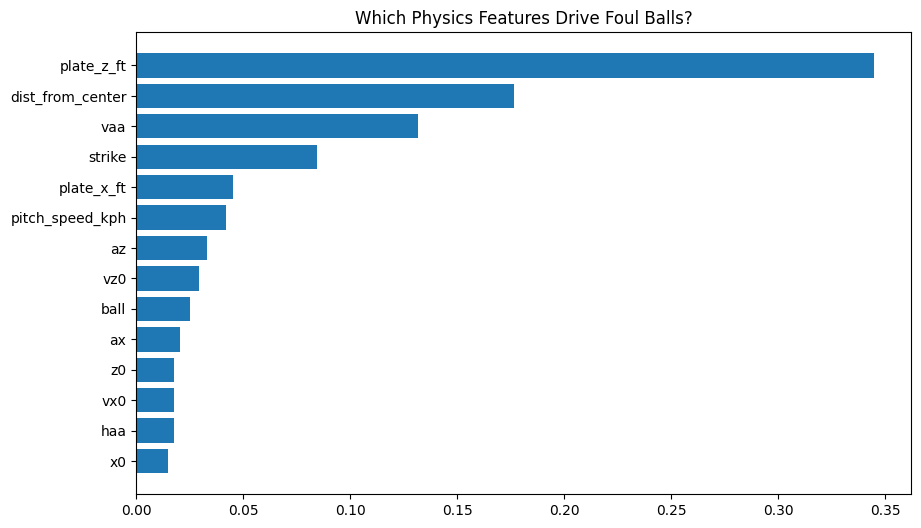

In [79]:
# Which Physics Features Drive Foul Balls? chart
# 1. plate_z_ft
# 2. dist_from_center
# 3. vaa
# 4. strike

import matplotlib.pyplot as plt

# Plotting Feature Importance
feature_importance = foul_model.feature_importances_
sorted_idx = np.argsort(feature_importance)

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [foul_features[i] for i in sorted_idx])
plt.title('Which Physics Features Drive Foul Balls?')
plt.show()

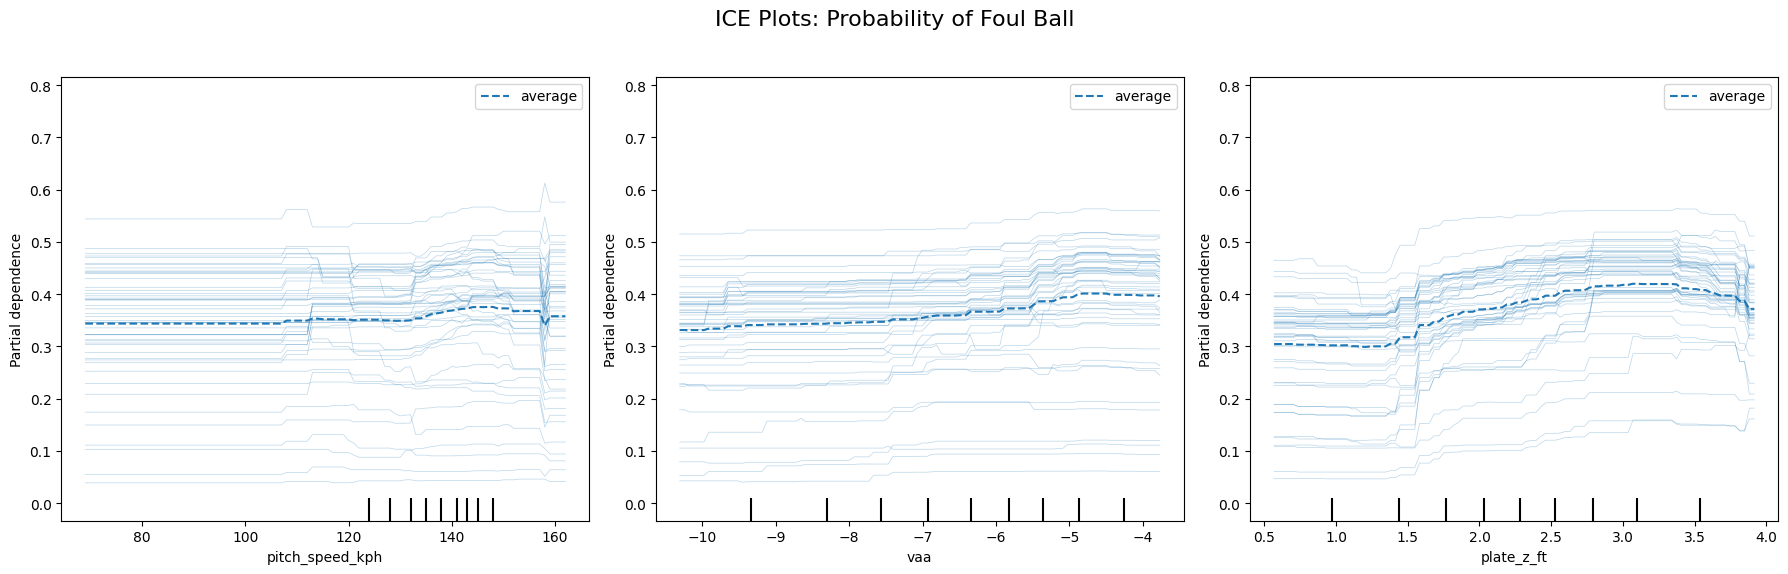

In [78]:
# ICE Plots: Probability of Foul Ball

import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

# 1. Prepare the plotting data (Convert everything to float)
# This prevents the "integer data" warning
X_ice = df[foul_features].fillna(0).astype(float)

# 2. Select features to inspect
features_to_plot = ['pitch_speed_kph', 'vaa', 'plate_z_ft']

# 3. Create the plot
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

display = PartialDependenceDisplay.from_estimator(
    foul_model, 
    X_ice, 
    features=features_to_plot,
    kind='both',          # 'both' shows individual lines (ICE) AND the average (PDP)
    subsample=50,         # 50 lines is plenty to see the "shape"
    random_state=42,
    ax=ax
)

# Pitch Speed Chart
ax[0].set_xlim(100, 165) 
ax[0].set_title("Pitch Speed (kph)")

# # VAA Chart (Vertical Approach Angle)
# ax[1].set_xlim(-12, -2) 
# ax[1].set_title("Vertical Approach Angle (VAA)")

# # Plate Height Chart
# ax[2].set_xlim(0, 5)
# ax[2].set_title("Plate Height (ft)")

plt.suptitle("ICE Plots: Probability of Foul Ball", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [64]:
# 1. Check for impossible speeds
zero_speeds = df[df['pitch_speed_kph'] < 50].shape[0]
print(f"🚩 Found {zero_speeds} pitches with impossible speeds (under 50 kph).")

# 2. Check for missing tracking data
missing_physics = df[df['ax'].isna() | df['vx0'].isna()].shape[0]
print(f"🚩 Found {missing_physics} pitches with missing tracking parameters.")

🚩 Found 13605 pitches with impossible speeds (under 50 kph).
🚩 Found 20417 pitches with missing tracking parameters.
✅ Cleaned data: 700483 pitches remaining.


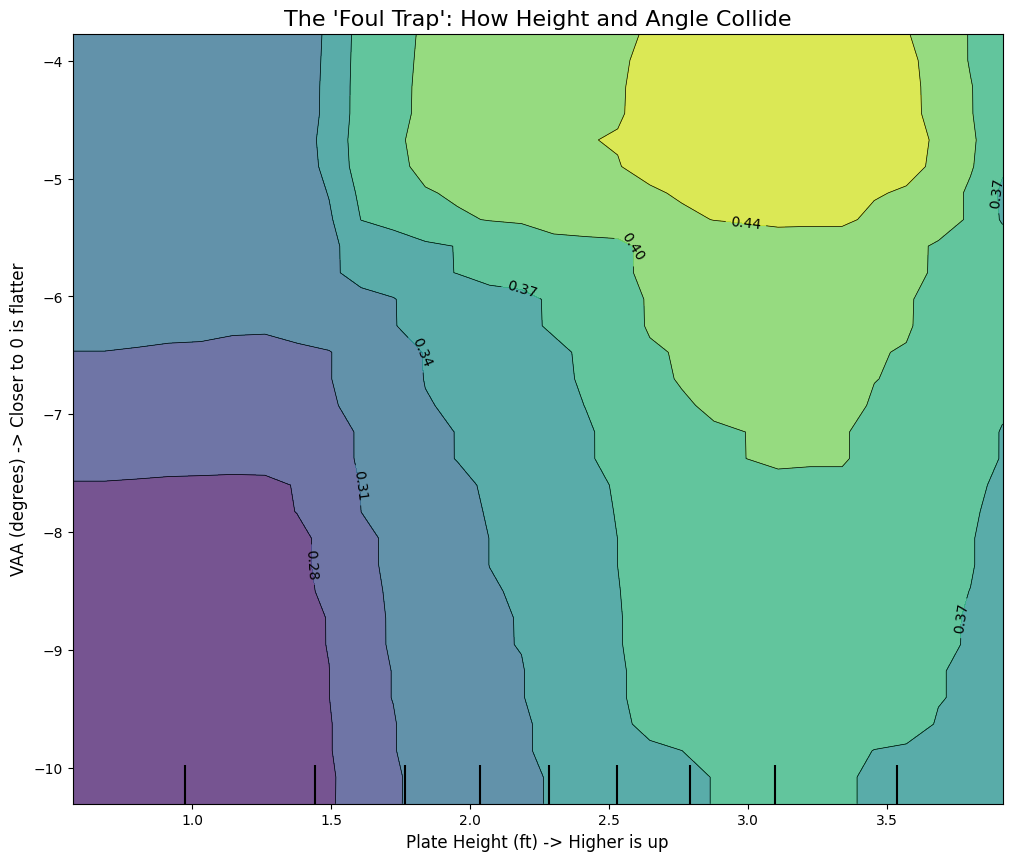

In [85]:
# plate height x vaa heatmap

from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# 1. Define the interaction pair
# We put Plate Height on the X-axis and VAA on the Y-axis
interact_features = [('plate_z_ft', 'vaa')]

# 2. Setup the plot
fig, ax = plt.subplots(figsize=(12, 10))

# 3. Generate the 2D Partial Dependence Plot
display = PartialDependenceDisplay.from_estimator(
    foul_model,
    df[foul_features].fillna(0).astype(float),
    features=interact_features,
    grid_resolution=30, # Higher resolution for a smoother heatmap
    contour_kw={'cmap': 'viridis', 'extend': 'both'}, # 'viridis' is great for seeing clear 'hot' zones
    ax=ax
)

#fig.colorbar(display.contours_[0, 0], ax=ax, label="Probability of Foul Ball")

# 4. Cleanup and Labels
plt.title("The 'Foul Trap': How Height and Angle Collide", fontsize=16)
plt.xlabel("Plate Height (ft) -> Higher is up", fontsize=12)
plt.ylabel("VAA (degrees) -> Closer to 0 is flatter", fontsize=12)

plt.show()